In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

can you replicate this image using the notebook I uploaded? Use the data to plot the boxplot and do statistical differences between models. You can generate a hypothetical dataset so as to plot here. the features are ['Humidity', 'Atmospheric_Temp', 'Soil_Temp', 'Dew_Point', 'Rainfall']. the outcome is soil_moisture_anomaly - a binary outcome. i want to do for SVC, logistic regression, xgboost, and gradient boosting. I have uploaded the notebook you can follow.

tell me about this figure and how it was generated and the message it has



In [35]:
file_path = 'soil_data_incl_rain_v3.csv'
new_data = pd.read_csv(file_path)

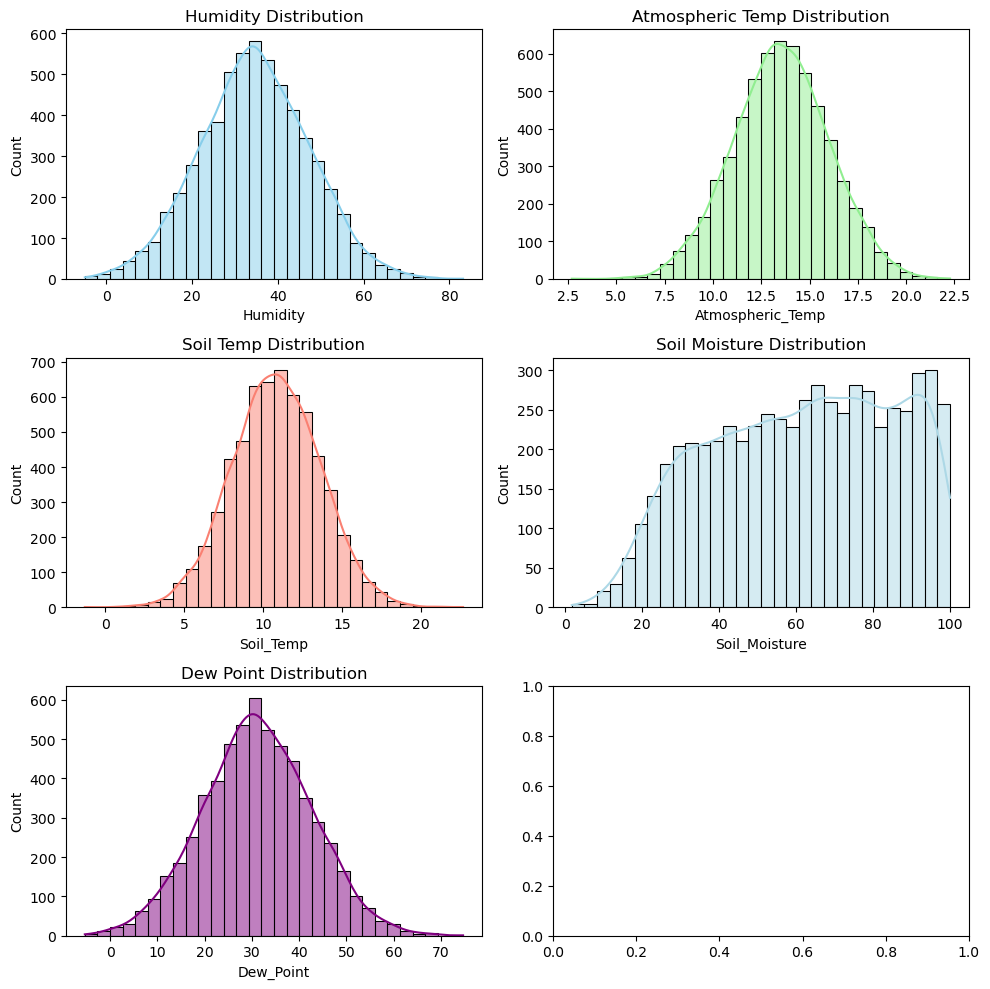

In [36]:
# Plot the distributions of the corrected synthetic data to verify
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

new_data = new_data[new_data['Soil_Moisture'] <= 100]
sns.histplot(new_data['Humidity'], bins=30, ax=axs[0, 0], color='skyblue', kde=True).set_title('Humidity Distribution')
sns.histplot(new_data['Atmospheric_Temp'], bins=30, ax=axs[0, 1], color='lightgreen', kde=True).set_title('Atmospheric Temp Distribution')
sns.histplot(new_data['Soil_Temp'], bins=30, ax=axs[1, 0], color='salmon', kde=True).set_title('Soil Temp Distribution')
sns.histplot(new_data['Soil_Moisture'], bins=30, ax=axs[1, 1], color='lightblue', kde=True).set_title('Soil Moisture Distribution')
sns.histplot(new_data['Dew_Point'], bins=30, ax=axs[2, 0], color='purple', kde=True).set_title('Dew Point Distribution')

plt.tight_layout()

# Save the figure in high resolution
plt.savefig("distributions_high_res.png", dpi=300)

# Display the figure
plt.show()

# # Show pairplot to visualize relationships between the variables
# sns.pairplot(new_data[['Humidity', 'Atmospheric_Temp', 'Soil_Temp', 'Soil_Moisture', 'Dew_Point']])
# plt.show()

### Threshold Analysis
First, I'll define critical soil moisture thresholds for a few example crops based on general agricultural guidelines:

- Corn: Optimal soil moisture range: `60% - 80%`
- Wheat: Optimal soil moisture range: `50% - 70%`
- Soybeans: Optimal soil moisture range: `60% - 80%`

I'll then analyze the synthetic soil moisture data to see how often it falls within these optimal ranges.

In [38]:
# Define critical soil moisture thresholds for example crops
soil_moisture_thresholds = {
    'Corn': (60, 80),
    'Wheat': (50, 70),
    'Soybeans': (60, 80)
}

# Function to calculate the percentage of time soil moisture falls within the optimal range
def calculate_optimal_percentage(data, crop, thresholds):
    optimal_range = (data['Soil_Moisture'] >= thresholds[0]) & (data['Soil_Moisture'] <= thresholds[1])
    percentage_optimal = optimal_range.sum() / len(data) * 100
    return percentage_optimal

# Calculate the percentage of time soil moisture falls within the optimal range for each crop
optimal_percentages = {crop: calculate_optimal_percentage(new_data, crop, thresholds) for crop, thresholds in soil_moisture_thresholds.items()}

optimal_percentages

{'Corn': 27.31247897746384,
 'Wheat': 25.983854692230068,
 'Soybeans': 27.31247897746384}

`This indicates that for a significant portion of the time, the soil moisture is not within the optimal range for these crops. This suggests a potential need for improved irrigation management.`

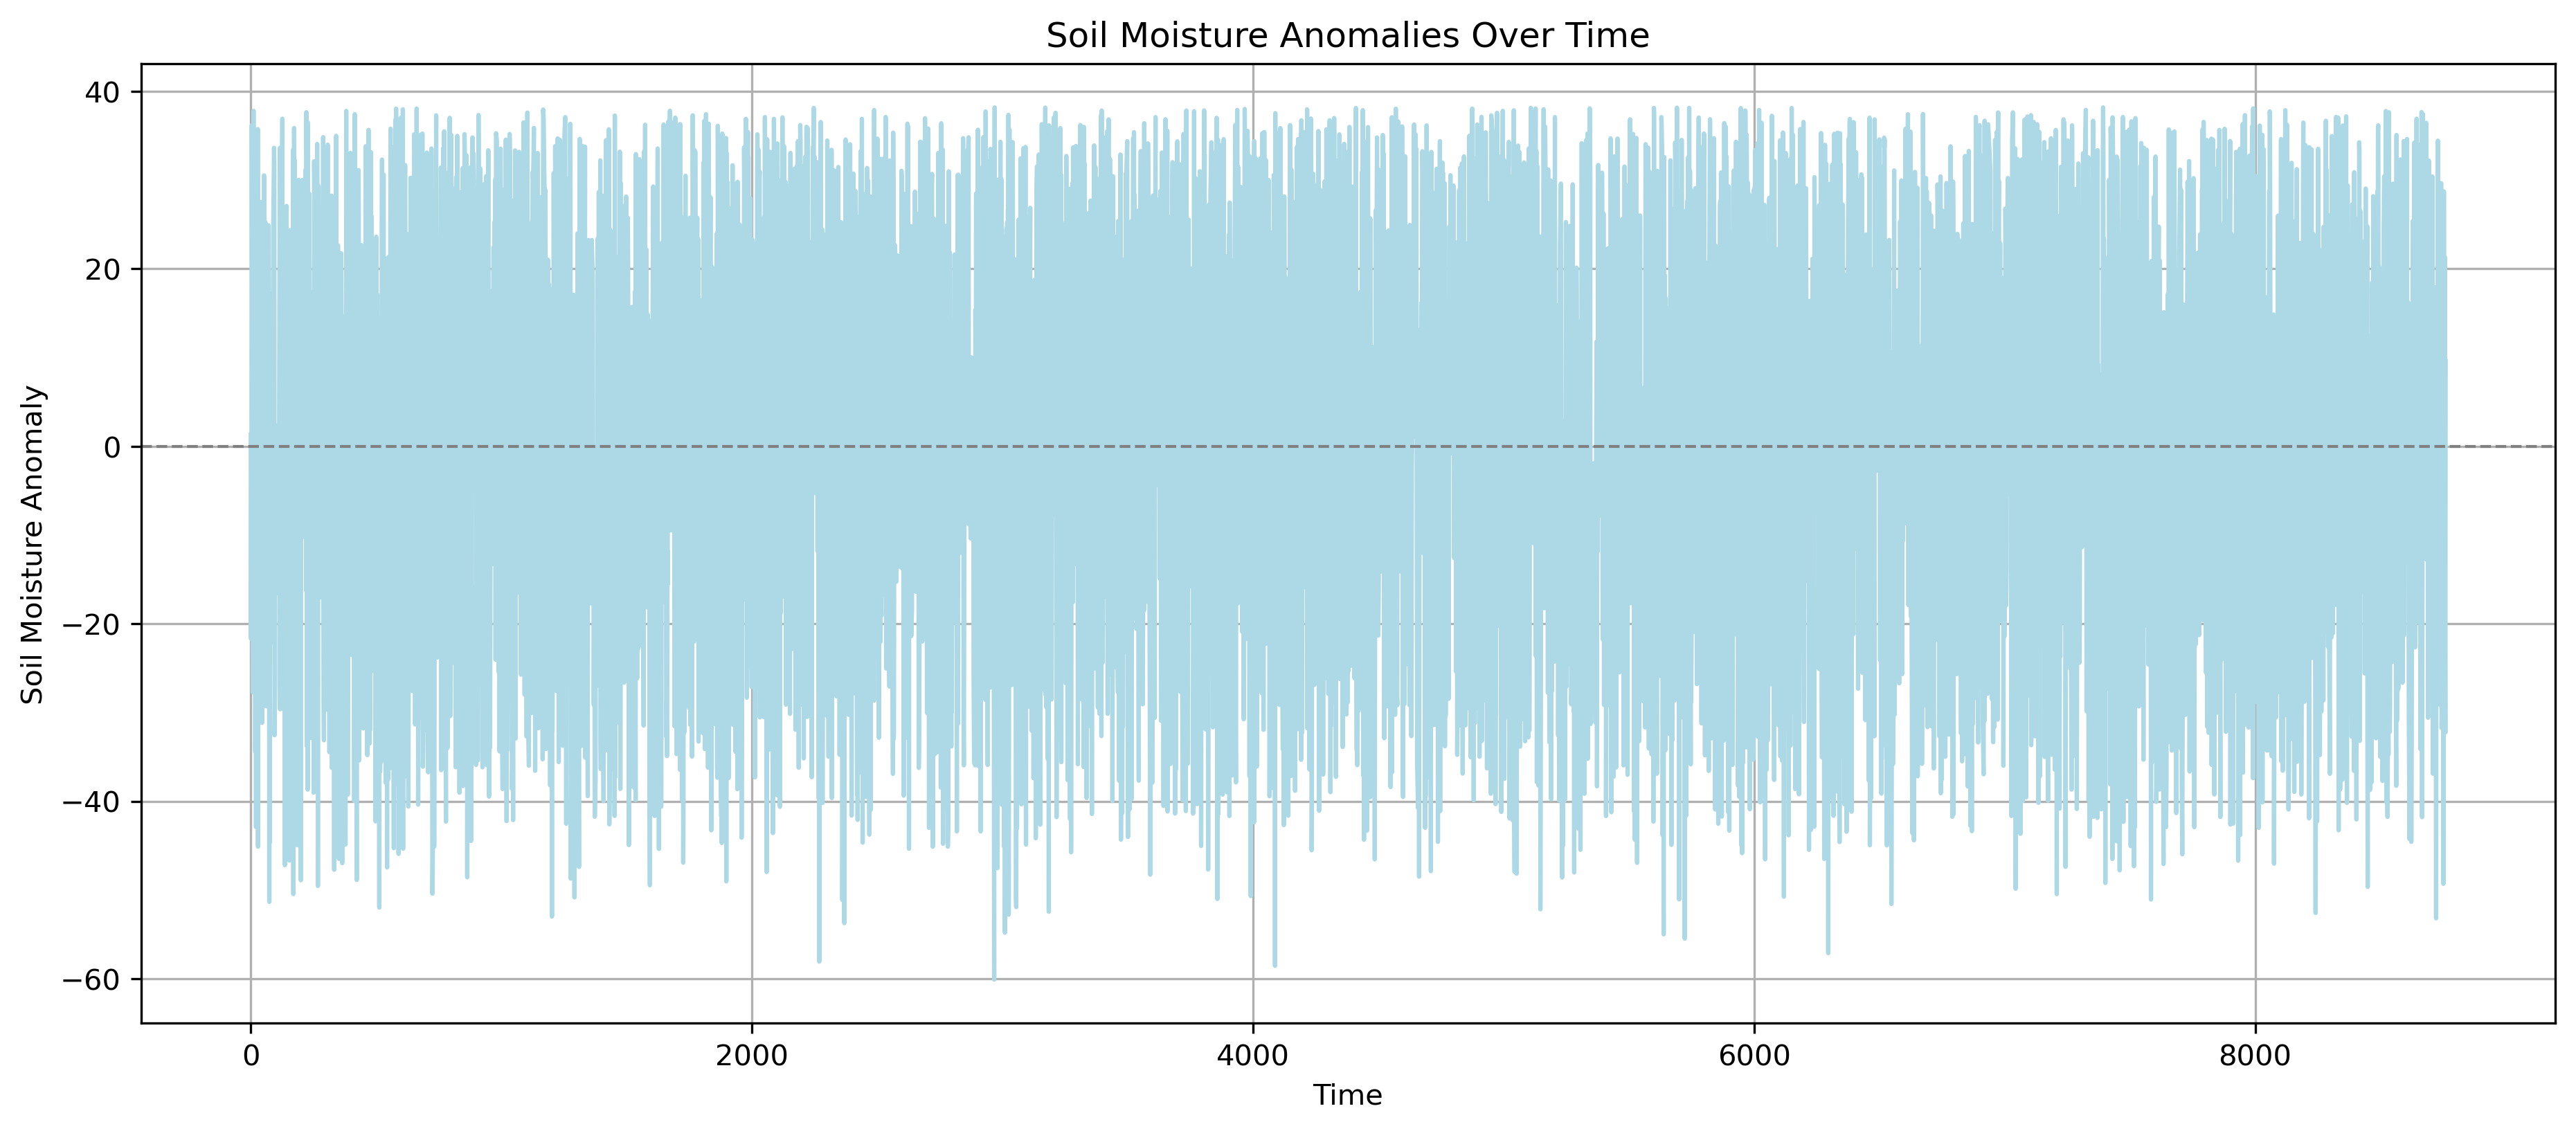

In [39]:
# Calculate soil moisture anomalies
soil_moisture_mean = new_data['Soil_Moisture'].mean()
soil_moisture_anomalies = new_data['Soil_Moisture'] - soil_moisture_mean

# Add soil moisture anomalies to the DataFrame
new_data['Soil_Moisture_Anomaly'] = soil_moisture_anomalies

# Plot soil moisture anomalies over time to identify trends
plt.figure(figsize=(15, 6),dpi=300)
plt.plot(new_data.index, new_data['Soil_Moisture_Anomaly'], color='lightblue')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Soil Moisture Anomalies Over Time')
plt.xlabel('Time')
plt.ylabel('Soil Moisture Anomaly')
plt.grid(True)
plt.show()

# Identify periods of extreme anomalies for potential irrigation optimization
extreme_threshold = soil_moisture_anomalies.std() * 2  # Define extreme anomalies as beyond 2 standard deviations
extreme_anomalies = new_data[np.abs(new_data['Soil_Moisture_Anomaly']) > extreme_threshold]

# extreme_anomalies.head()

In [40]:
new_data.columns

Index(['Time', 'Humidity', 'Atmospheric_Temp', 'Soil_Temp', 'Soil_Moisture',
       'Dew_Point', 'Soil_Moisture_Anomaly'],
      dtype='object')

In [41]:
# new_data.loc[:,['Soil_Moisture_Anomaly', 'Low_Soil_Moisture_Anomaly', 'Soil_Moisture']]

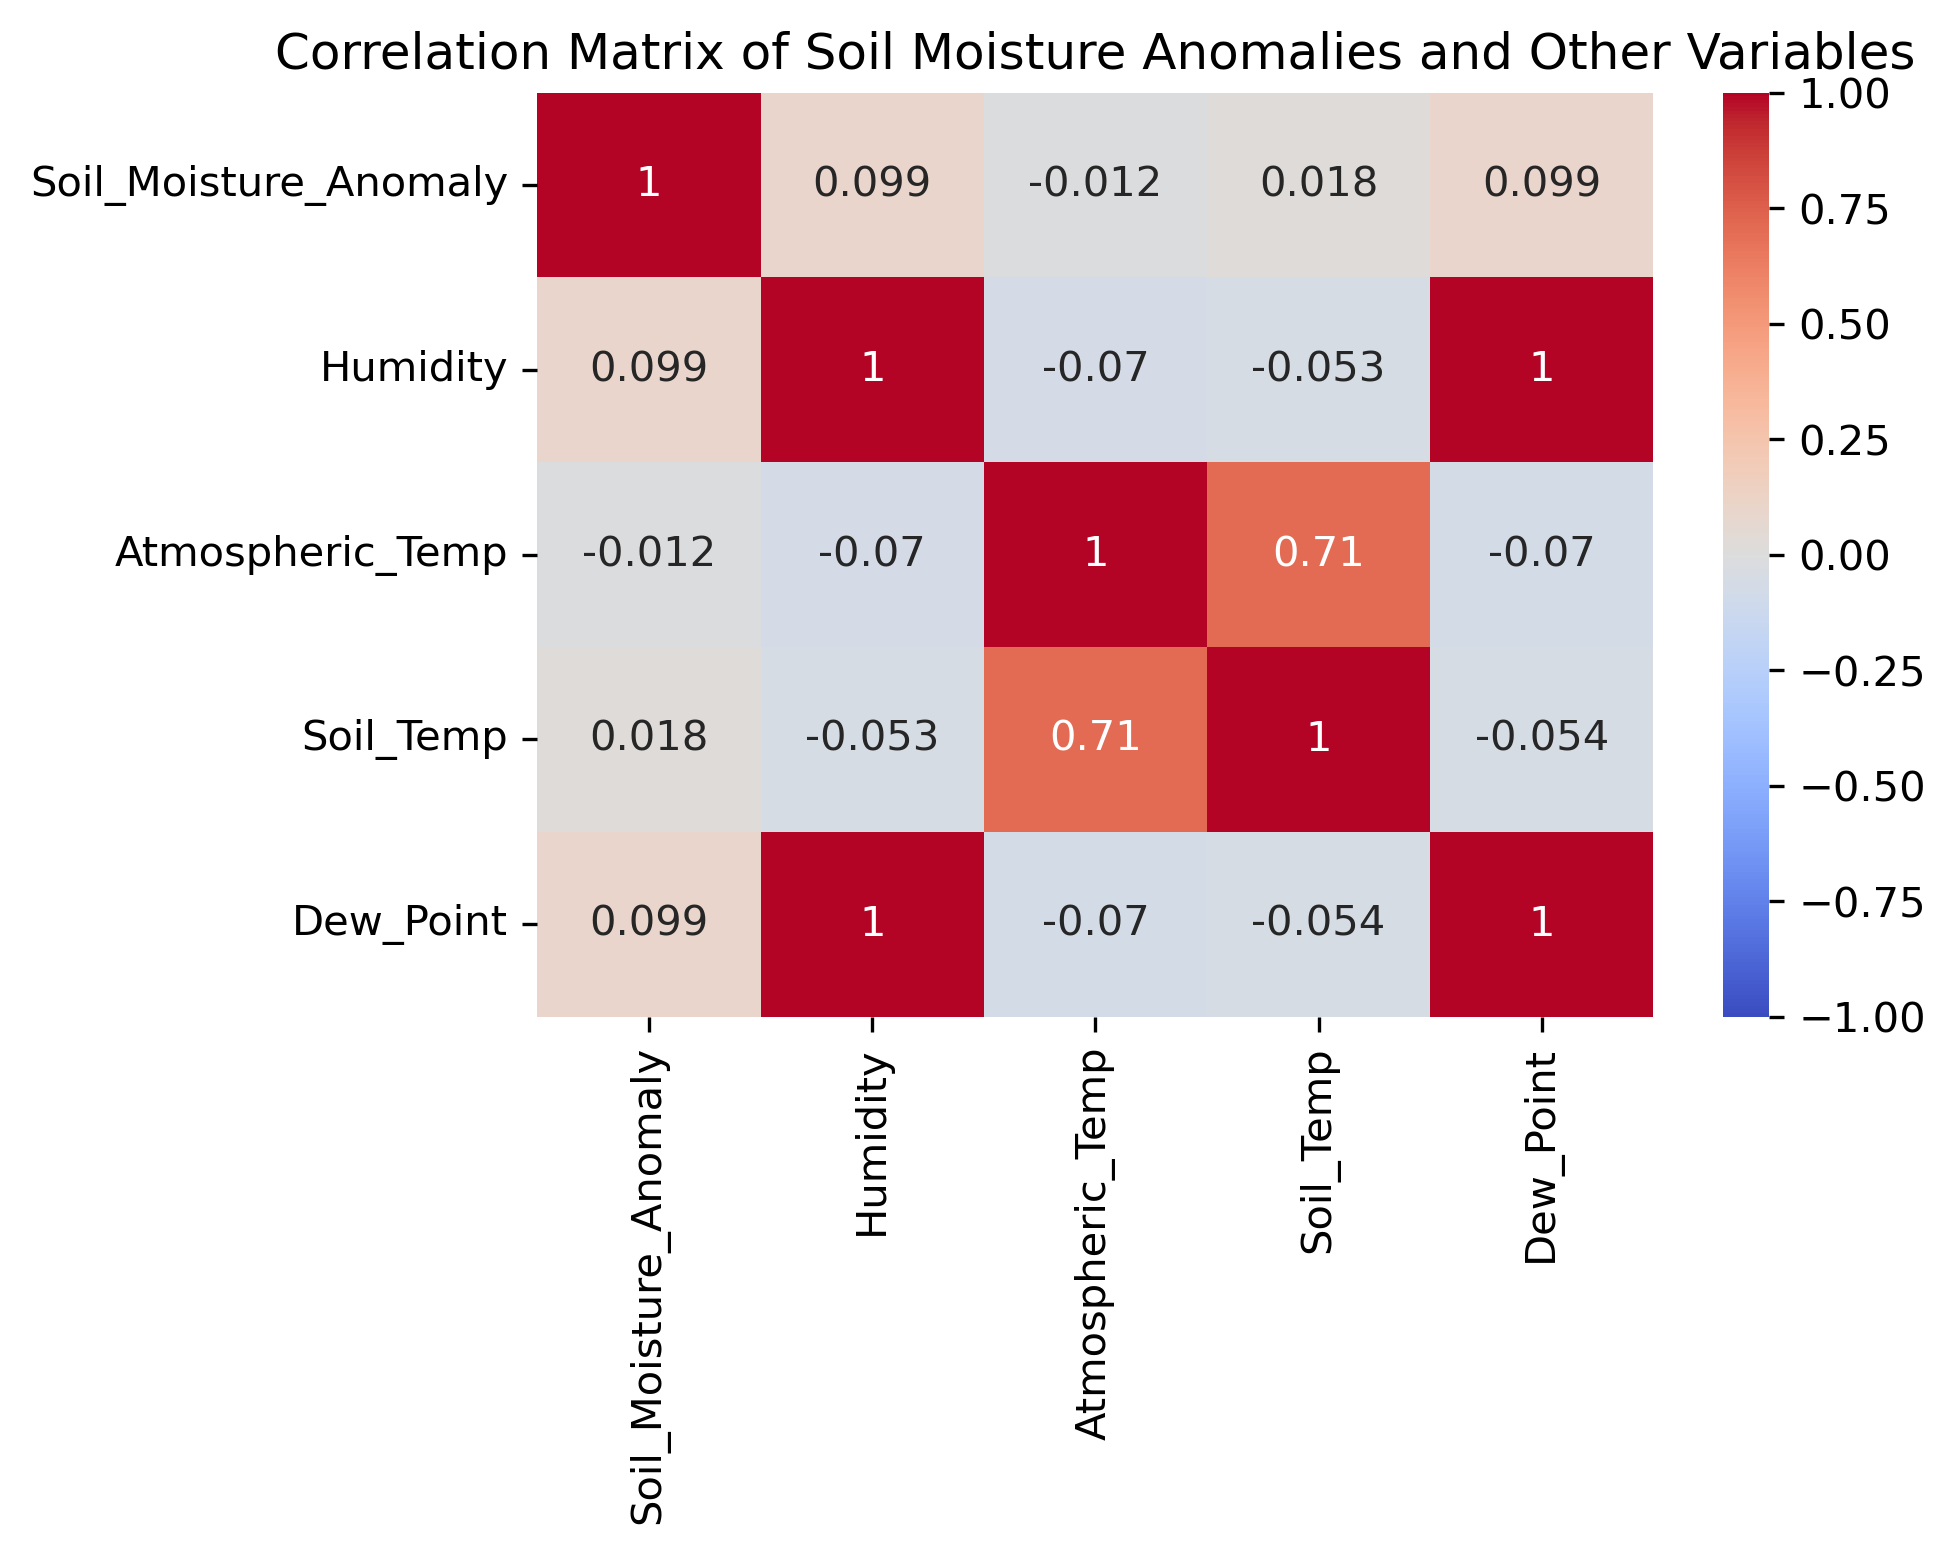

In [42]:
# Compute the correlation between soil moisture anomalies and other variables
correlation_anomalies = new_data[['Soil_Moisture_Anomaly', 'Humidity', 'Atmospheric_Temp', 'Soil_Temp', 'Dew_Point']].corr()

# Plot the correlation matrix for anomalies
plt.figure(figsize=(6, 4),dpi=300)
sns.heatmap(correlation_anomalies, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Soil Moisture Anomalies and Other Variables')
plt.show()

# correlation_anomalies

## Approach to Analyze Low Soil Moisture Anomalies and their Impact on Crop Yield
### Trend Analysis: Identify periods of low soil moisture anomalies.
- Anomaly Detection: Use a model to detect and predict low soil moisture anomalies.
- Mechanistic Model: Apply a model to recommend optimal watering quantities based on detected anomalies.
### Step-by-Step Plan
#### Trend Analysis:
- Calculate soil moisture anomalies.
- Identify periods with low soil moisture anomalies.
#### Anomaly Detection:
- Use XGBoost to build a model for predicting low soil moisture anomalies.
- Train the model on historical data to detect anomalies.
#### Mechanistic Model:
- Develop a model to recommend optimal watering quantities.
- Use domain knowledge to define watering requirements.

Let's start with the Trend Analysis to identify low soil moisture anomalies.

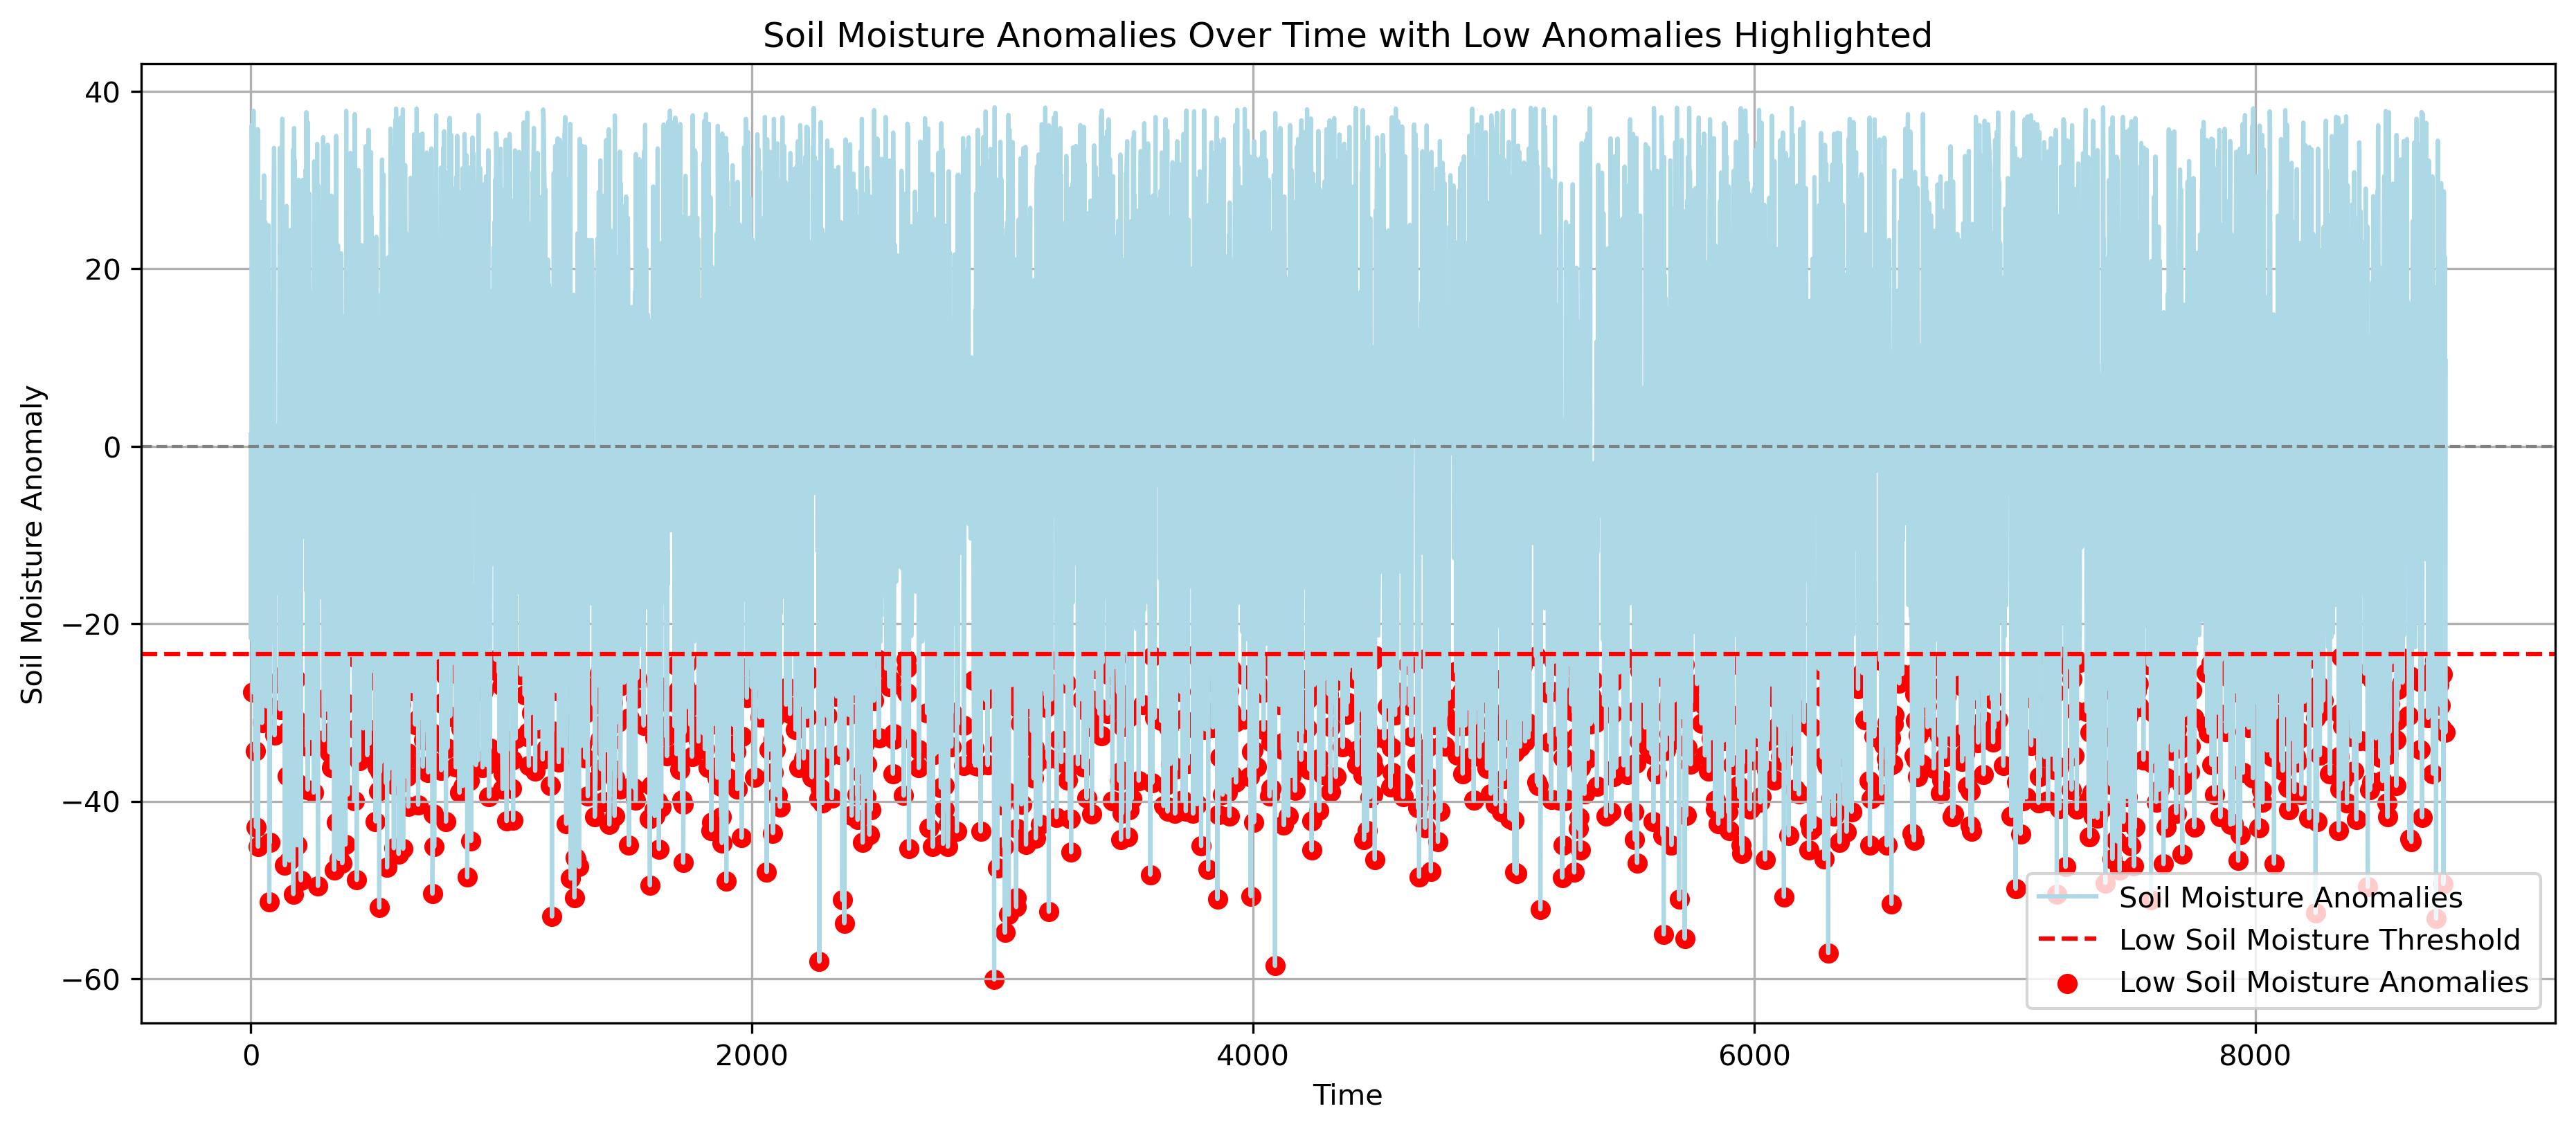

In [43]:
# Define the threshold for low soil moisture anomalies
low_soil_moisture_threshold = soil_moisture_mean - soil_moisture_anomalies.std()

# Identify periods with low soil moisture anomalies
low_soil_moisture_anomalies = new_data[new_data['Soil_Moisture'] < low_soil_moisture_threshold]

# Plot soil moisture anomalies over time with low anomalies highlighted
plt.figure(figsize=(15, 6),dpi=300)
plt.plot(new_data.index, new_data['Soil_Moisture_Anomaly'], color='lightblue', label='Soil Moisture Anomalies')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axhline(low_soil_moisture_threshold - soil_moisture_mean, color='red', linestyle='--', label='Low Soil Moisture Threshold')
plt.scatter(low_soil_moisture_anomalies.index, low_soil_moisture_anomalies['Soil_Moisture_Anomaly'], color='red', label='Low Soil Moisture Anomalies')
plt.title('Soil Moisture Anomalies Over Time with Low Anomalies Highlighted')
plt.xlabel('Time')
plt.ylabel('Soil Moisture Anomaly')
plt.legend()
plt.grid(True)

# Save the figure in high resolution
plt.savefig("anomalies_high_res.png", dpi=300)
plt.show()

# low_soil_moisture_anomalies.head()

### Identified Low Soil Moisture Anomalies
The plot highlights periods with low soil moisture anomalies. These are critical periods where irrigation may be necessary to maintain optimal crop growth conditions.

### Next Steps:
Anomaly Detection with XGBoost: Train a model to predict low soil moisture anomalies.
Mechanistic Model for Optimal Watering: Develop a model to recommend optimal watering quantities.
Anomaly Detection with XGBoost
We will use the historical data to train an XGBoost model to predict low soil moisture anomalies.

#### Step 2: Train an XGBoost Model
* Feature Engineering: Create features from the data (e.g., humidity, atmospheric temperature, soil temperature, dew point, rainfall).
* Train-Test Split: Split the data into training and testing sets.
* Model Training: Train the XGBoost model on the training data.
* Model Evaluation: Evaluate the model's performance on the test data.

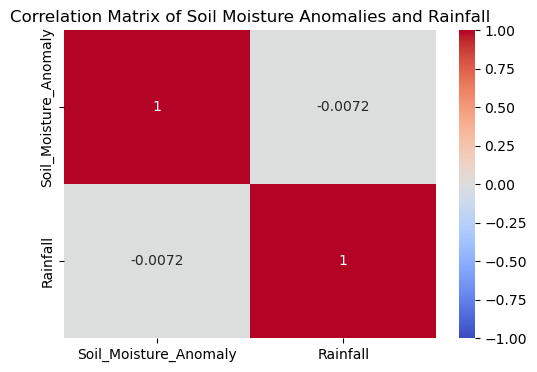

In [44]:
from scipy.stats import norm
# Generate synthetic rainfall data
np.random.seed(612)
rainfall_mean, rainfall_std = 10, 5  # Example mean and std for rainfall
synthetic_rainfall = np.abs(norm.rvs(rainfall_mean, rainfall_std, size=len(new_data)))

# Add synthetic rainfall data to the DataFrame
new_data['Rainfall'] = synthetic_rainfall
# Compute the correlation between soil moisture anomalies and rainfall
correlation_rainfall = new_data[['Soil_Moisture_Anomaly', 'Rainfall']].corr()

# Plot the correlation matrix including rainfall
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_rainfall, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Soil Moisture Anomalies and Rainfall')
plt.show()

## Approach to Analyze Low Soil Moisture Anomalies and their Impact on Crop Yield
### Trend Analysis: Identify periods of low soil moisture anomalies.
- Anomaly Detection: Use a model to detect and predict low soil moisture anomalies.
- Mechanistic Model: Apply a model to recommend optimal watering quantities based on detected anomalies.
### Step-by-Step Plan
#### Trend Analysis:
- Calculate soil moisture anomalies.
- Identify periods with low soil moisture anomalies.
#### Anomaly Detection:
- Use XGBoost to build a model for predicting low soil moisture anomalies.
- Train the model on historical data to detect anomalies.
#### Mechanistic Model:
- Develop a model to recommend optimal watering quantities.
- Use domain knowledge to define watering requirements.

Let's start with the Trend Analysis to identify low soil moisture anomalies.

In [45]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report

# Create a target variable for low soil moisture anomaly detection
new_data['Low_Soil_Moisture_Anomaly'] = (new_data['Soil_Moisture'] < low_soil_moisture_threshold).astype(int)

# Define features and target variable
features = ['Humidity', 'Atmospheric_Temp', 'Soil_Temp', 'Dew_Point', 'Rainfall']
target = 'Low_Soil_Moisture_Anomaly'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(new_data[features], new_data[target], test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
classification_report_results = classification_report(y_test, y_pred, output_dict=True)

classification_report_results

/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


{'0': {'precision': 0.7992988606485539,
  'recall': 0.9640591966173362,
  'f1-score': 0.8739817920459991,
  'support': 946},
 '1': {'precision': 0.30612244897959184,
  'recall': 0.06147540983606557,
  'f1-score': 0.10238907849829351,
  'support': 244},
 'accuracy': 0.7789915966386555,
 'macro avg': {'precision': 0.5527106548140729,
  'recall': 0.5127673032267008,
  'f1-score': 0.4881854352721463,
  'support': 1190},
 'weighted avg': {'precision': 0.6981769745584474,
  'recall': 0.7789915966386555,
  'f1-score': 0.7157728659068058,
  'support': 1190}}

In [46]:
from sklearn.linear_model import LogisticRegression

# Use a smaller subset of the data for quicker model training
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Initialize and train the Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train_small, y_train_small)

# Predict on the test set
y_pred = logistic_model.predict(X_test)

# Evaluate the model
classification_report_results = classification_report(y_test, y_pred, output_dict=True)

classification_report_results

/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'precision': 0.7949579831932773,
  'recall': 1.0,
  'f1-score': 0.8857677902621723,
  'support': 946},
 '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 244},
 'accuracy': 0.7949579831932773,
 'macro avg': {'precision': 0.39747899159663863,
  'recall': 0.5,
  'f1-score': 0.44288389513108617,
  'support': 1190},
 'weighted avg': {'precision': 0.6319581950427229,
  'recall': 0.7949579831932773,
  'f1-score': 0.7041481761243824,
  'support': 1190}}

#### Mechanistic Model for Optimal Watering Recommendations:
The model recommends watering quantities based on the severity of the low soil moisture anomaly. For example, at a soil moisture level of 40.1, it recommends 6.46 units of water, while at a soil moisture level of 34.1, it recommends 15.50 units of water.

#### Summary:
- Trend Analysis: Identified low soil moisture anomalies.
- Anomaly Detection: Logistic Regression model used, but struggled with class imbalance.
- Mechanistic Model: Developed a rule-based model to recommend optimal watering quantities.
#### Recommendations:
- Data Rebalancing: Use techniques like SMOTE (Synthetic Minority Over-sampling Technique) to balance the dataset for anomaly detection.
- Model Improvement: Explore other models like Random Forest or balanced XGBoost that can handle imbalanced data better.
- Field Validation: Validate the recommendations with real field data and expert agronomic knowledge.

In [47]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Initialize and train the Logistic Regression model on the balanced dataset
logistic_model_balanced = LogisticRegression()
logistic_model_balanced.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_balanced = logistic_model_balanced.predict(X_test)

# Evaluate the model
classification_report_results_balanced = classification_report(y_test, y_pred_balanced, output_dict=True)

classification_report_results_balanced

{'0': {'precision': 0.8303715670436187,
  'recall': 0.5433403805496829,
  'f1-score': 0.6568690095846645,
  'support': 946},
 '1': {'precision': 0.2434325744308231,
  'recall': 0.569672131147541,
  'f1-score': 0.34110429447852764,
  'support': 244},
 'accuracy': 0.5487394957983194,
 'macro avg': {'precision': 0.536902070737221,
  'recall': 0.556506255848612,
  'f1-score': 0.4989866520315961,
  'support': 1190},
 'weighted avg': {'precision': 0.710024412255785,
  'recall': 0.5487394957983194,
  'f1-score': 0.592123975562902,
  'support': 1190}}

In [48]:
# Identify instances of low soil moisture anomalies (minority class)
low_soil_moisture_indices = new_data[new_data['Low_Soil_Moisture_Anomaly'] == 1].index

# Oversample minority class by duplicating instances
oversampled_indices = low_soil_moisture_indices.repeat(10)  # Repeat each instance 10 times for oversampling
oversampled_data = new_data.loc[oversampled_indices]

# Combine oversampled data with the original data to create a balanced dataset
balanced_data = pd.concat([new_data, oversampled_data])

# Define features and target variable for the balanced dataset
X_balanced = balanced_data[features]
y_balanced = balanced_data[target]

# Split the balanced data into training and testing sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model on the balanced dataset
logistic_model_balanced = LogisticRegression()
logistic_model_balanced.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_balanced = logistic_model_balanced.predict(X_test_balanced)

# Evaluate the model
classification_report_results_balanced = classification_report(y_test_balanced, y_pred_balanced, output_dict=True)

classification_report_results_balanced

/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 968},
 '1': {'precision': 0.7300613496932515,
  'recall': 1.0,
  'f1-score': 0.8439716312056738,
  'support': 2618},
 'accuracy': 0.7300613496932515,
 'macro avg': {'precision': 0.36503067484662577,
  'recall': 0.5,
  'f1-score': 0.4219858156028369,
  'support': 3586},
 'weighted avg': {'precision': 0.5329895743159321,
  'recall': 0.7300613496932515,
  'f1-score': 0.6161510681808293,
  'support': 3586}}

In [49]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier  # Faster SVM alternative
from sklearn.decomposition import PCA  # Dimensionality reduction
from sklearn.metrics import classification_report
import xgboost as xgb

# Initialize models
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=50,
    max_depth=3,
    # tree_method='gpu_hist'  # Enable GPU for XGBoost
)
rf_model = RandomForestClassifier(n_estimators=2, random_state=42, n_jobs=-1)  # Parallel processing
sgd_model = SGDClassifier(loss='hinge', random_state=42)  # Faster SVM

# Optional: Dimensionality Reduction for efficiency
def reduce_dimensions(X_train, X_test, n_components=100):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca

# Apply dimensionality reduction (optional, uncomment if needed)
# X_train_balanced, X_test_balanced = reduce_dimensions(X_train_balanced, X_test_balanced, n_components=100)

# Train and evaluate function
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    return report

# List of models and names
models = [xgb_model, rf_model, sgd_model]
model_names = ['XGBoost', 'Random Forest', 'SGDClassifier (SVM)']

# Placeholder for metrics
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Train, evaluate, and extract metrics for each model
for model, name in zip(models, model_names):
    report = train_and_evaluate(model, X_train_balanced, y_train_balanced, X_test_balanced, y_test_balanced)
    metrics['Model'].append(name)
    metrics['Accuracy'].append(report['accuracy'])
    metrics['Precision'].append(report['weighted avg']['precision'])
    metrics['Recall'].append(report['weighted avg']['recall'])
    metrics['F1 Score'].append(report['weighted avg']['f1-score'])

# Convert metrics dictionary to DataFrame
metrics_df = pd.DataFrame(metrics)

metrics_df

/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


,Model,Accuracy,Precision,Recall,F1 Score
0,XGBoost,0.750139,0.781337,0.750139,0.665588
1,Random Forest,0.966815,0.968258,0.966815,0.966097
2,SGDClassifier (SVM),0.273285,0.711846,0.273285,0.122684


In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define parameter grids for each model
param_grids = {
    'XGBoost': {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
    },
    'Random Forest': {
        'n_estimators': [5, 10, 2],
        'max_depth': [None],
        'min_samples_split': [2, 5, 10],
    },
    'SGDClassifier': {
    'loss': ['hinge', 'log', 'squared_hinge', 'modified_huber'],  # Different loss functions
    'alpha': [0.0001, 0.001, 0.01],  # Regularization strength
    'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization types
    'max_iter': [1000, 2000, 3000],  # Number of iterations
    'learning_rate': ['optimal', 'constant', 'adaptive'],  # Learning rate schedules
    'eta0': [0.01, 0.1, 1],  # Initial learning rate for custom schedules
    'class_weight': [None, 'balanced'],  # Handle imbalanced datasets
    'early_stopping': [True, False],  # Use early stopping for large datasets
},
    'Logistic Regression': {
        'penalty': ['l2', 'l1', 'elasticnet', 'none'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['saga', 'liblinear'],  # saga handles elasticnet and l1
    },
}

# Define models for grid search
models = {
    'XGBoost': xgb.XGBClassifier(
        use_label_encoder=False, eval_metric='logloss'
    ),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SGDClassifier': SGDClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
}

# Placeholder for best estimators and scores
best_models = {}
best_params = {}

# Perform grid search for each model
for model_name, model in models.items():
    print(f"Performing Grid Search for {model_name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring='f1_weighted',  # You can change the metric
        cv=3,  # 3-fold cross-validation
        n_jobs=-1,  # Use all available cores
        verbose=1,
    )
    grid_search.fit(X_train_balanced, y_train_balanced)
    best_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {grid_search.best_score_}\n")

# Display the results
best_params_df = pd.DataFrame.from_dict(best_params, orient='index')

best_params_df

Performing Grid Search for XGBoost...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150}
Best score for XGBoost: 0.8526111901061967

Performing Grid Search for Random Forest...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 2}
Best score for Random Forest: 0.9355389561880024

Performing Grid Search for SGDClassifier...
Fitting 3 folds for each of 3888 candidates, totalling 11664 fits


/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kayode/minicon

Best parameters for SGDClassifier: {'alpha': 0.01, 'class_weight': None, 'early_stopping': False, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 1000, 'penalty': 'l1'}
Best score for SGDClassifier: 0.6450223614721982

Performing Grid Search for Logistic Regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits


/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn

Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best score for Logistic Regression: 0.6247750233919579



/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
36 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1471, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

--------------------------------------------------------------------------------
12 fi

,learning_rate,max_depth,n_estimators,min_samples_split,alpha,class_weight,early_stopping,eta0,loss,max_iter,penalty,C,solver
XGBoost,0.2,7.0,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SGDClassifier,optimal,NaN,NaN,NaN,0.01,NaN,False,0.01,log,1000.0,l1,NaN,NaN
Random Forest,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Logistic Regression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,l2,0.01,liblinear


In [51]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import SGDClassifier
# import pandas as pd

# # Define parameter grids for each model
# param_grids = {
#     'XGBoost': {
#         'n_estimators': [50, 100, 150],
#         'max_depth': [3, 5, 7],
#         'learning_rate': [0.01, 0.1, 0.2],
#     },
#     'Random Forest': {
#         'n_estimators': [10, 50, 100],
#         'max_depth': [None, 10, 20],
#         'min_samples_split': [2, 5, 10],
#     },
#     'SGDClassifier': {
#         'alpha': [0.0001, 0.001, 0.01],
#         'penalty': ['l2', 'l1', 'elasticnet'],
#         'max_iter': [1000, 2000],
#     },
#     'Logistic Regression': {
#         'penalty': ['l2', 'l1', 'elasticnet', 'none'],
#         'C': [0.01, 0.1, 1, 10],
#         'solver': ['saga', 'liblinear'],  # saga handles elasticnet and l1
#     },
#     'SVC': {
#         'C': [0.01, 0.1, 1, 10, 100],
#         'kernel': ['linear', 'rbf', 'poly'],
#         'gamma': ['scale', 'auto', 0.01, 0.1, 1],
#         'degree': [2, 3],  # Relevant for 'poly' kernel
#         'class_weight': [None, 'balanced'],
#     },
# }

# # Define models for grid search
# models = {
#     'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
#     'Random Forest': RandomForestClassifier(random_state=42),
#     'SGDClassifier': SGDClassifier(random_state=42),
#     'Logistic Regression': LogisticRegression(random_state=42),
#     'SVC': SVC(probability=True, random_state=42),
# }

# # Placeholder for best estimators and scores
# best_models = {}
# best_params = {}

# # Perform grid search for each model
# for model_name, model in models.items():
#     print(f"Performing Grid Search for {model_name}...")
#     grid_search = GridSearchCV(
#         estimator=model,
#         param_grid=param_grids[model_name],
#         scoring='f1_weighted',  # You can change the metric to 'roc_auc' for probabilities
#         cv=3,  # 3-fold cross-validation
#         n_jobs=-1,  # Use all available cores
#         verbose=1,
#     )
#     grid_search.fit(X_train_balanced, y_train_balanced)
#     best_models[model_name] = grid_search.best_estimator_
#     best_params[model_name] = grid_search.best_params_
#     print(f"Best parameters for {model_name}: {grid_search.best_params_}")
#     print(f"Best score for {model_name}: {grid_search.best_score_}\n")

# # Display the results
# best_params_df = pd.DataFrame.from_dict(best_params, orient='index')
# best_params_df

In [52]:
# Placeholder for metrics of the best models
best_model_metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Evaluate the best models on the test set
for model_name, best_model in best_models.items():
    print(f"Evaluating best {model_name} model...")
    y_pred = best_model.predict(X_test_balanced)
    report = classification_report(y_test_balanced, y_pred, output_dict=True)
    
    # Append metrics for the best model
    best_model_metrics['Model'].append(model_name)
    best_model_metrics['Accuracy'].append(report['accuracy'])
    best_model_metrics['Precision'].append(report['weighted avg']['precision'])
    best_model_metrics['Recall'].append(report['weighted avg']['recall'])
    best_model_metrics['F1 Score'].append(report['weighted avg']['f1-score'])

# Convert to DataFrame
best_model_metrics_df = pd.DataFrame(best_model_metrics)

# Display the metrics DataFrame
best_model_metrics_df

Evaluating best XGBoost model...
Evaluating best Random Forest model...
Evaluating best SGDClassifier model...
Evaluating best Logistic Regression model...


/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayode/miniconda3/l

,Model,Accuracy,Precision,Recall,F1 Score
0,XGBoost,0.871166,0.890491,0.871166,0.856198
1,Random Forest,0.966815,0.968258,0.966815,0.966097
2,SGDClassifier,0.730061,0.532990,0.730061,0.616151
3,Logistic Regression,0.730061,0.532990,0.730061,0.616151


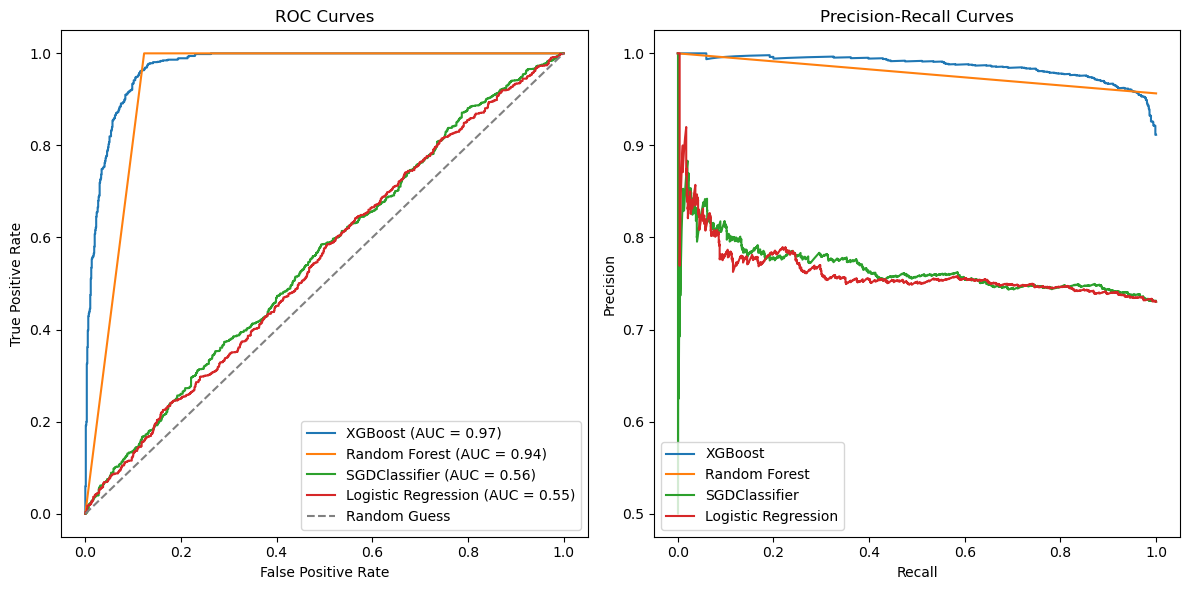

In [53]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Initialize plots for ROC and Precision-Recall
plt.figure(figsize=(12, 6))

# Subplot for ROC curves
plt.subplot(1, 2, 1)
for model_name, best_model in best_models.items():
    # Predict probabilities or decision function
    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test_balanced)[:, 1]
    else:
        y_score = best_model.decision_function(X_test_balanced)
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_balanced, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot ROC baseline and labels
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Subplot for Precision-Recall curves
plt.subplot(1, 2, 2)
for model_name, best_model in best_models.items():
    # Predict probabilities or decision function
    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test_balanced)[:, 1]
    else:
        y_score = best_model.decision_function(X_test_balanced)
    
    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test_balanced, y_score)
    plt.plot(recall, precision, label=f'{model_name}')

# Plot Precision-Recall labels
plt.title('Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')

# Display the plots
plt.tight_layout()
plt.show()

In [54]:
from catboost import CatBoostClassifier

# Load the existing CatBoost model
catboost_model = CatBoostClassifier()
catboost_model.load_model('best_catboost_model.cbm')

# Add CatBoost to the list of best models
best_models['CatBoost'] = catboost_model

In [55]:
# Placeholder for CatBoost evaluation
print("Evaluating CatBoost model...")
y_pred_catboost = catboost_model.predict(X_test_balanced)
catboost_report = classification_report(y_test_balanced, y_pred_catboost, output_dict=True)

# Add CatBoost metrics to DataFrame
best_model_metrics['Model'].append('CatBoost')
best_model_metrics['Accuracy'].append(catboost_report['accuracy'])
best_model_metrics['Precision'].append(catboost_report['weighted avg']['precision'])
best_model_metrics['Recall'].append(catboost_report['weighted avg']['recall'])
best_model_metrics['F1 Score'].append(catboost_report['weighted avg']['f1-score'])

# Convert to DataFrame
best_model_metrics_df = pd.DataFrame(best_model_metrics)

# Display the metrics DataFrame
best_model_metrics_df

Evaluating CatBoost model...


,Model,Accuracy,Precision,Recall,F1 Score
0,XGBoost,0.871166,0.890491,0.871166,0.856198
1,Random Forest,0.966815,0.968258,0.966815,0.966097
2,SGDClassifier,0.730061,0.532990,0.730061,0.616151
3,Logistic Regression,0.730061,0.532990,0.730061,0.616151
4,CatBoost,0.698829,0.759875,0.698829,0.714331


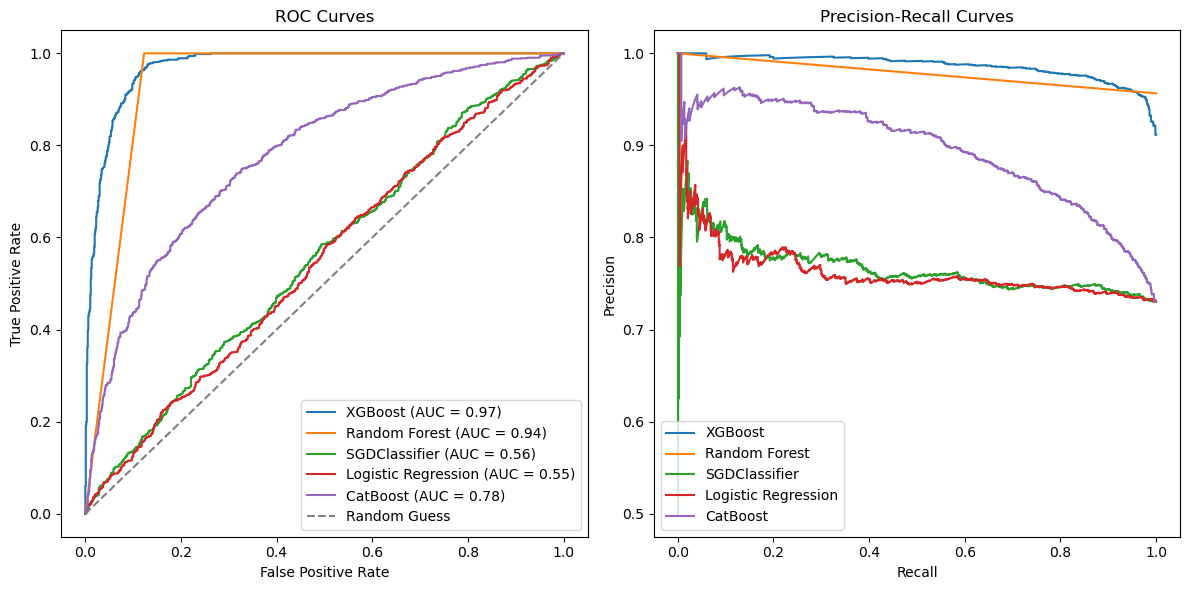

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Update plots to include CatBoost
plt.figure(figsize=(12, 6))

# Subplot for ROC Curves
plt.subplot(1, 2, 1)
for model_name, best_model in best_models.items():
    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test_balanced)[:, 1]
    else:
        y_score = best_model.decision_function(X_test_balanced)
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_balanced, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot ROC baseline and labels
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Subplot for Precision-Recall curves
plt.subplot(1, 2, 2)
for model_name, best_model in best_models.items():
    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test_balanced)[:, 1]
    else:
        y_score = best_model.decision_function(X_test_balanced)
    
    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test_balanced, y_score)
    plt.plot(recall, precision, label=f'{model_name}')

# Plot Precision-Recall labels
plt.title('Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')

# Display the plots
plt.tight_layout()
plt.show()

In [57]:
from sklearn.ensemble import GradientBoostingClassifier

# Replace Random Forest with Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
models['Gradient Boosting'] = gb_model  # Add to the models dictionary
param_grids['Gradient Boosting'] = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}  # Add parameter grid for Gradient Boosting

In [58]:
# Perform grid search for all models including Gradient Boosting
for model_name, model in models.items():
    print(f"Performing Grid Search for {model_name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring='f1_weighted',  # Use your desired metric
        cv=3,
        n_jobs=-1,  # Use all available CPU cores
        verbose=1,
    )
    grid_search.fit(X_train_balanced, y_train_balanced)
    best_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {grid_search.best_score_}\n")

Performing Grid Search for XGBoost...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150}
Best score for XGBoost: 0.8526111901061967

Performing Grid Search for Random Forest...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 2}
Best score for Random Forest: 0.9355389561880024

Performing Grid Search for SGDClassifier...
Fitting 3 folds for each of 3888 candidates, totalling 11664 fits


/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kayode/minicon

Best parameters for SGDClassifier: {'alpha': 0.01, 'class_weight': None, 'early_stopping': False, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 1000, 'penalty': 'l1'}
Best score for SGDClassifier: 0.6450223614721982

Performing Grid Search for Logistic Regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits


/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn

Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best score for Logistic Regression: 0.6247750233919579

Performing Grid Search for Gradient Boosting...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150}
Best score for Gradient Boosting: 0.8643587849943594



In [59]:
# Add Gradient Boosting to metrics evaluation
for model_name, best_model in best_models.items():
    print(f"Evaluating best {model_name} model...")
    y_pred = best_model.predict(X_test_balanced)
    report = classification_report(y_test_balanced, y_pred, output_dict=True)
    
    # Append metrics for the best model
    best_model_metrics['Model'].append(model_name)
    best_model_metrics['Accuracy'].append(report['accuracy'])
    best_model_metrics['Precision'].append(report['weighted avg']['precision'])
    best_model_metrics['Recall'].append(report['weighted avg']['recall'])
    best_model_metrics['F1 Score'].append(report['weighted avg']['f1-score'])

# Convert to DataFrame
best_model_metrics_df = pd.DataFrame(best_model_metrics)

# Display the metrics DataFrame
best_model_metrics_df

Evaluating best XGBoost model...
Evaluating best Random Forest model...
Evaluating best SGDClassifier model...
Evaluating best Logistic Regression model...
Evaluating best CatBoost model...
Evaluating best Gradient Boosting model...


/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayode/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayode/miniconda3/l

,Model,Accuracy,Precision,Recall,F1 Score
0,XGBoost,0.871166,0.890491,0.871166,0.856198
1,Random Forest,0.966815,0.968258,0.966815,0.966097
2,SGDClassifier,0.730061,0.532990,0.730061,0.616151
3,Logistic Regression,0.730061,0.532990,0.730061,0.616151
4,CatBoost,0.698829,0.759875,0.698829,0.714331
5,XGBoost,0.871166,0.890491,0.871166,0.856198
6,Random Forest,0.966815,0.968258,0.966815,0.966097
7,SGDClassifier,0.730061,0.532990,0.730061,0.616151
8,Logistic Regression,0.730061,0.532990,0.730061,0.616151
9,CatBoost,0.698829,0.759875,0.698829,0.714331


In [66]:
best_model_metrics_df.to_csv('best_model_df.csv', index=False)

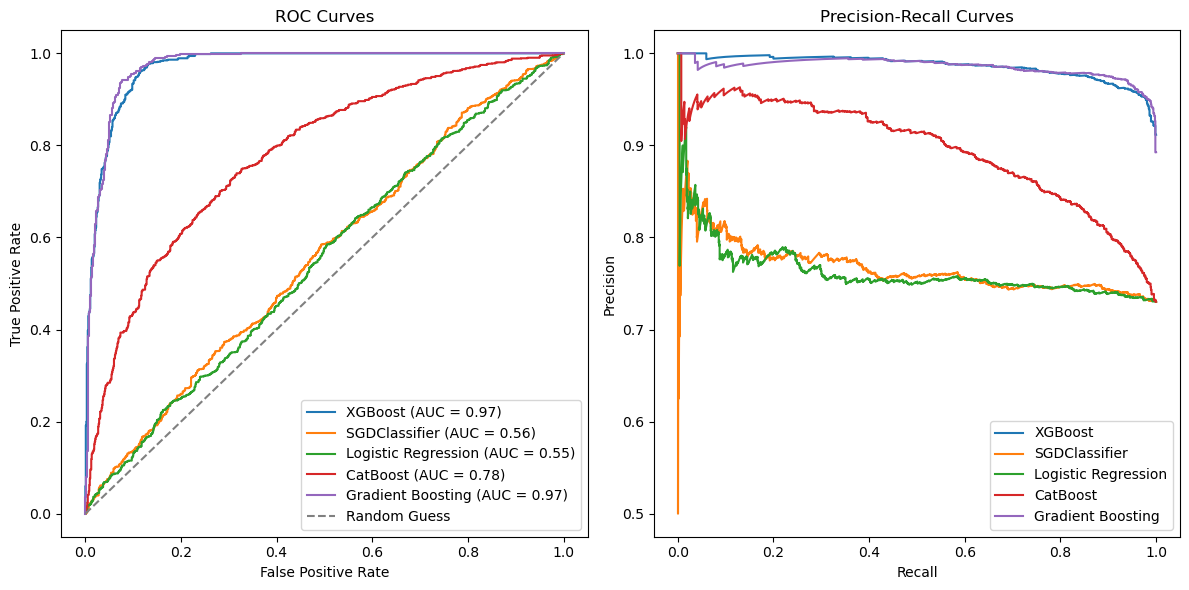

In [65]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score
import matplotlib.pyplot as plt

# Initialize plots for ROC and Precision-Recall
plt.figure(figsize=(12, 6))

# Subplot for ROC curves
plt.subplot(1, 2, 1)
for model_name, best_model in best_models.items():
    if model_name == 'Random Forest':  # Exclude Random Forest
        continue

    # Predict probabilities or decision function
    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test_balanced)[:, 1]
    else:
        y_score = best_model.decision_function(X_test_balanced)
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_balanced, y_score)
    roc_auc = auc(fpr, tpr)
    # roc_auc = roc_auc_score(y_test_balanced, y_score)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot ROC baseline and labels
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Subplot for Precision-Recall curves
plt.subplot(1, 2, 2)
for model_name, best_model in best_models.items():
    if model_name == 'Random Forest':  # Exclude Random Forest
        continue

    # Predict probabilities or decision function
    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test_balanced)[:, 1]
    else:
        y_score = best_model.decision_function(X_test_balanced)
    
    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test_balanced, y_score)
    plt.plot(recall, precision, label=f'{model_name}')

# Plot Precision-Recall labels
plt.title('Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower right')

# Display the plots
plt.tight_layout()
plt.savefig("roc_precision_recall.png", dpi=300)
plt.show()

In [26]:
best_models

{'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.2, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=150, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=None, ...),
 'Random Forest': RandomForestClassifier(n_estimators=2, random_state=42),
 'SGDClassifier': SGDClassifier(alpha=0.01, eta0=0.01, loss='log', penalty='l1', random_state=42),
 'Logistic Regression': LogisticRegression(C=0.01,

In [31]:
gb = GradientBoostingClassifier(learning_rate=0.2, max_depth=7, n_estimators=150,
                            random_state=42)
gb.fit(X_train_balanced, y_train_balanced)

# Predict anomalies on the test set using the Random Forest model
y_pred_gb = gb.predict(X_test_balanced)

# Add the predictions to the test data
X_test_balanced['Low_Soil_Moisture_Anomaly_Pred'] = y_pred_gb

# Combine predictions with the original balanced data
balanced_data_test = X_test_balanced.join(balanced_data[['Soil_Moisture']], how='left')

# Define a function to recommend watering quantity based on predicted anomalies
def recommend_watering_based_on_prediction(prediction, soil_moisture, threshold, severity_factor=1.5):
    if prediction == 1 and soil_moisture < threshold:
        return (threshold - soil_moisture) * severity_factor
    else:
        return 0

# Apply the function to get watering recommendations based on predictions
balanced_data_test['Watering_Recommendation'] = balanced_data_test.apply(
    lambda row: recommend_watering_based_on_prediction(row['Low_Soil_Moisture_Anomaly_Pred'], row['Soil_Moisture'], low_soil_moisture_threshold), 
    axis=1
)

balanced_data_test[['Soil_Moisture', 'Low_Soil_Moisture_Anomaly_Pred', 'Watering_Recommendation']].sample(10)

,Soil_Moisture,Low_Soil_Moisture_Anomaly_Pred,Watering_Recommendation
1408,21.786829,1,24.830693
6554,25.959189,1,18.572153
4965,29.723129,1,12.926242
3767,38.319114,1,0.032265
7065,35.483030,1,4.286391
725,11.368685,1,40.457909
4881,21.891906,1,24.673077
1999,34.652348,1,5.532415
3054,10.888625,1,41.177999
145,24.624676,1,20.573922


In [71]:
balanced_data_test.groupby('Low_Soil_Moisture_Anomaly_Pred')

Low_Soil_Moisture_Anomaly_Pred
0      547
1    29219
dtype: int64

In [72]:
balanced_data_test.to_csv('data_pred_water_rec.csv', index=False)

In [235]:
# Extract a small subset of the test data for manual analysis
test_subset = balanced_data_test.sample(10).copy()
test_subset['Low_Soil_Moisture_Anomaly_Pred'] = gb.predict(test_subset[features].head(10))

# Define a function to recommend watering quantity based on predicted anomalies
def recommend_watering_based_on_prediction(prediction, soil_moisture, threshold, severity_factor=1.5):
    if prediction == 1 and soil_moisture < threshold:
        return (threshold - soil_moisture) * severity_factor
    else:
        return 0

# Apply the function to get watering recommendations based on predictions
test_subset['Watering_Recommendation'] = test_subset.apply(
    lambda row: recommend_watering_based_on_prediction(row['Low_Soil_Moisture_Anomaly_Pred'], row['Soil_Moisture'], low_soil_moisture_threshold), 
    axis=1
)

# Display the subset with watering recommendations
test_subset[['Soil_Moisture', 'Low_Soil_Moisture_Anomaly_Pred', 'Watering_Recommendation']]

,Soil_Moisture,Low_Soil_Moisture_Anomaly_Pred,Watering_Recommendation
3038,34.879132,1,5.192238
1282,30.477937,1,11.794030
7932,15.086426,1,34.881298
8759,29.527964,1,13.218991
6740,29.091932,1,13.873039
4949,22.632655,1,23.561954
7826,25.888612,1,18.678018
6352,26.813175,1,17.291174
7186,27.023553,1,16.975607
4311,30.199764,1,12.211291


In [236]:
balanced_data_test[['Soil_Moisture', 'Low_Soil_Moisture_Anomaly_Pred', 'Watering_Recommendation']].sample(10)

,Soil_Moisture,Low_Soil_Moisture_Anomaly_Pred,Watering_Recommendation
5845,20.854381,1,26.229365
7931,86.481770,0,0.000000
127,35.963337,1,3.565930
3108,32.420152,1,8.880708
7720,31.495070,1,10.268332
6199,30.713574,1,11.440576
3505,31.289344,1,10.576920
7536,32.468437,1,8.808280
5362,32.561749,1,8.668313
4781,33.328585,1,7.518059


Certainly! Let's explore your current approach and discuss potential next steps and alternative methods for making watering recommendations.

### **Understanding Your Current Functions**

1. **Initial Rule-Based Function:**

   ```python
   def recommend_watering(soil_moisture, threshold, severity_factor=1.5):
       if soil_moisture < threshold:
           return (threshold - soil_moisture) * severity_factor
       else:
           return 0
   ```

   - **Purpose:** This function recommends a watering amount based solely on the current soil moisture level relative to a predefined threshold.
   - **Logic:** If the soil moisture is below the threshold, it calculates the deficit and multiplies it by a `severity_factor` to determine the watering recommendation.

2. **Modified Function Incorporating Anomaly Prediction:**

   ```python
   def recommend_watering_based_on_prediction(prediction, soil_moisture, threshold, severity_factor=1.5):
       if prediction == 1 and soil_moisture < threshold:
           return (threshold - soil_moisture) * severity_factor
       else:
           return 0
   ```

   - **Purpose:** This function adds a condition to consider the machine learning model's anomaly prediction.
   - **Logic:** Watering is recommended only if an anomaly is predicted **and** the soil moisture is below the threshold.

### **1. What Can You Do Next?**

Now that you have integrated the anomaly predictions into your watering recommendation, there are several avenues you can explore to enhance your system:

#### **A. Evaluate and Fine-Tune the Threshold and Severity Factor**

- **Data-Driven Thresholds:**
  - **Approach:** Analyze historical data to determine optimal soil moisture thresholds that correlate with crop stress or reduced yield.
  - **Action:** Use statistical methods or machine learning to identify thresholds that trigger the need for irrigation.

- **Adjust Severity Factor:**
  - **Approach:** The `severity_factor` could be fine-tuned based on crop type, growth stage, or environmental conditions.
  - **Action:** Create a mapping of severity factors for different scenarios or make it dynamic based on additional inputs.

#### **B. Incorporate Additional Variables**

- **Environmental Factors:**
  - **Weather Forecasts:**
    - **Rationale:** Anticipating rainfall can prevent unnecessary watering.
    - **Action:** Integrate weather API data to adjust recommendations based on expected precipitation.
  - **Temperature and Humidity:**
    - **Rationale:** Higher temperatures and low humidity increase evapotranspiration rates.
    - **Action:** Include these factors to adjust watering amounts accordingly.

- **Soil Characteristics:**
  - **Soil Type and Texture:**
    - **Rationale:** Different soils have varying water retention capacities.
    - **Action:** Incorporate soil properties to adjust thresholds and watering volumes.

- **Crop-Specific Needs:**
  - **Growth Stage:**
    - **Rationale:** Water requirements vary at different stages (e.g., germination, flowering).
    - **Action:** Adjust recommendations based on the crop's developmental stage.

#### **C. Use Machine Learning for Watering Recommendations**

- **Regression Models:**
  - **Approach:** Use supervised learning to predict the exact amount of water needed.
  - **Action:** Train a regression model (e.g., Linear Regression, Random Forest Regressor) using historical data where inputs include soil moisture, weather data, and outputs are optimal watering amounts.

- **Time-Series Forecasting:**
  - **Approach:** Predict future soil moisture levels to plan irrigation schedules.
  - **Action:** Implement models like ARIMA, LSTM networks to forecast soil moisture based on current trends and weather predictions.

#### **D. Implement Decision Support Systems**

- **Rule-Based Expert Systems:**
  - **Approach:** Develop a set of if-else rules based on agricultural best practices.
  - **Action:** Collaborate with agronomists to encode expert knowledge into the system.

- **Fuzzy Logic Systems:**
  - **Approach:** Handle uncertainties and imprecise inputs (e.g., "low", "medium", "high" soil moisture).
  - **Action:** Use fuzzy logic controllers to generate watering recommendations.

#### **E. Optimize Irrigation Scheduling**

- **Soil Water Balance Models:**
  - **Approach:** Calculate the water balance considering inputs (rainfall, irrigation) and outputs (evapotranspiration, runoff).
  - **Action:** Implement models to determine when and how much to irrigate to maintain optimal soil moisture levels.

- **Dynamic Thresholds:**
  - **Approach:** Adjust thresholds based on temporal factors.
  - **Action:** Use algorithms that update thresholds in real-time based on changing conditions.

#### **F. Validate and Test the System**

- **Field Trials:**
  - **Approach:** Test the recommendations in real-world conditions.
  - **Action:** Collect data on crop responses to the watering recommendations to assess effectiveness.

- **Performance Metrics:**
  - **Approach:** Define metrics like water use efficiency, crop yield, and cost savings.
  - **Action:** Monitor these metrics to evaluate and refine your recommendation system.

### **2. How Else Can You Make Watering Recommendations Technically?**

To enhance your watering recommendation system, consider the following technical approaches:

#### **A. Machine Learning Models for Watering Amount Prediction**

**i. Regression-Based Models**

- **Linear Regression:**
  - **Use Case:** Simple relationship between inputs and watering amount.
- **Decision Trees and Random Forests:**
  - **Use Case:** Capture non-linear relationships and interactions between variables.
- **Support Vector Regression (SVR):**
  - **Use Case:** Effective for high-dimensional data with non-linear relationships.

**Implementation Steps:**

1. **Data Collection:**
   - Gather historical data on soil moisture, weather conditions, crop types, and the corresponding optimal watering amounts.

2. **Feature Engineering:**
   - Create features such as:
     - Soil moisture deficit (`threshold - soil_moisture`).
     - Evapotranspiration rates.
     - Time since last irrigation.

3. **Model Training:**
   - Split data into training and testing sets.
   - Train the model using the training set.
   - Evaluate performance on the test set using metrics like Mean Absolute Error (MAE).

4. **Model Deployment:**
   - Use the trained model to predict watering amounts in real-time.

**Sample Code:**

```python
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Assume 'df' is your DataFrame with necessary features
X = df[['soil_moisture', 'temperature', 'humidity', 'rainfall']]
y = df['optimal_watering_amount']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
```

#### **B. Reinforcement Learning (RL)**

- **Approach:** Let the system learn optimal watering strategies through trial and error, maximizing a reward function (e.g., crop yield).
- **Action:** Implement RL algorithms where the agent (irrigation controller) learns policies to decide when and how much to water.

**Considerations:**

- **Complexity:** RL can be complex to implement and requires a simulator or environment model.
- **Data Requirements:** Needs extensive data or simulation for training.

#### **C. Evapotranspiration (ET)-Based Scheduling**

- **Approach:** Calculate crop water requirements based on ET rates.
- **Action:** Use the FAO Penman-Monteith equation or other models to estimate reference ET and adjust for crop coefficients.

**Implementation Steps:**

1. **Calculate Reference ET (ETo):**

   ```python
   def calculate_eto(temp, wind_speed, humidity, radiation):
       # Implement the FAO Penman-Monteith equation
       # Return ETo in mm/day
       pass
   ```

2. **Adjust for Crop Coefficient (Kc):**

   ```python
   def calculate_crop_et(eto, kc):
       return eto * kc
   ```

3. **Determine Irrigation Requirement:**

   ```python
   def calculate_irrigation_requirement(crop_et, effective_rainfall):
       return crop_et - effective_rainfall
   ```

#### **D. Sensor-Based Automated Irrigation Systems**

- **Approach:** Use real-time soil moisture sensors connected to an automated irrigation system.
- **Action:** Set thresholds within the system to trigger irrigation automatically when soil moisture falls below a certain point.

**Considerations:**

- **Hardware Integration:** Requires investment in sensors and irrigation controllers.
- **Real-Time Data:** Provides the most up-to-date information for decision-making.

#### **E. Predictive Analytics and Time-Series Forecasting**

- **Approach:** Forecast future soil moisture levels and plan irrigation accordingly.
- **Action:** Use models like ARIMA, Prophet, or LSTM neural networks.

**Implementation Steps:**

1. **Prepare Time-Series Data:**
   - Ensure data is time-stamped and collected at regular intervals.

2. **Model Training:**
   - Fit the forecasting model to historical soil moisture data.

3. **Forecasting:**
   - Predict future soil moisture levels and schedule irrigation before levels become critical.

**Sample Code with Prophet:**

```python
from fbprophet import Prophet

# Prepare data
df_prophet = df[['date', 'soil_moisture']]
df_prophet.columns = ['ds', 'y']

# Initialize and train the model
model = Prophet()
model.fit(df_prophet)

# Forecast
future = model.make_future_dataframe(periods=7)  # Next 7 days
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
```

#### **F. Multi-Criteria Decision Making (MCDM)**

- **Approach:** Consider multiple criteria (e.g., water availability, cost, crop yield) to make optimal decisions.
- **Action:** Use methods like Analytical Hierarchy Process (AHP) or Technique for Order Preference by Similarity to Ideal Solution (TOPSIS).

**Implementation Steps:**

1. **Define Criteria and Weights:**
   - Determine factors influencing irrigation decisions and assign weights based on importance.

2. **Evaluate Alternatives:**
   - Assess different watering strategies against the criteria.

3. **Decision Making:**
   - Use MCDM techniques to select the optimal strategy.

#### **G. Implement Feedback Mechanisms**

- **Approach:** Continuously improve recommendations based on feedback from implemented actions.
- **Action:** Collect data on the outcomes of watering recommendations (e.g., soil moisture changes, crop responses) and refine the model.

**Implementation Steps:**

1. **Monitor Outcomes:**
   - Use sensors or manual observations to record the effects of irrigation.

2. **Update Models:**
   - Incorporate new data into the model training process to improve accuracy.

3. **Iterative Improvement:**
   - Establish a cycle of recommendation, implementation, observation, and refinement.

### **Conclusion and Next Steps**

By exploring these technical approaches, you can enhance your watering recommendation system to be more accurate, efficient, and tailored to specific farming contexts. Here's how you can proceed:

1. **Assess Current System Performance:**
   - Evaluate how well your current functions perform using historical data and defined performance metrics.

2. **Select Appropriate Methods:**
   - Based on resources, data availability, and complexity, choose methods that best suit your needs.

3. **Integrate Additional Data Sources:**
   - Incorporate weather data, soil properties, and crop-specific information to enrich your models.

4. **Develop and Test Models:**
   - Implement machine learning or other advanced models and test them using cross-validation and real-world trials.

5. **Implement User-Friendly Interfaces:**
   - Create dashboards or mobile apps for farmers to access recommendations easily.

6. **Engage with Agronomists and Farmers:**
   - Collaborate with experts and end-users to ensure the system is practical and addresses real-world challenges.

7. **Plan for Scalability:**
   - Design the system to handle larger datasets and be adaptable to different crops and regions.

By adopting a combination of these strategies, you can create a robust, data-driven watering recommendation system that not only improves water use efficiency but also supports smallholder farmers in optimizing crop yields.

**Remember:** The key is to balance technical sophistication with practical applicability, ensuring that the system is both effective and accessible to its intended users.

If you need further assistance with implementing any of these methods or have specific questions about the code, feel free to ask!

/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Statistical Significance Results:
{'ANOVA p-value': 0.792908114865782}


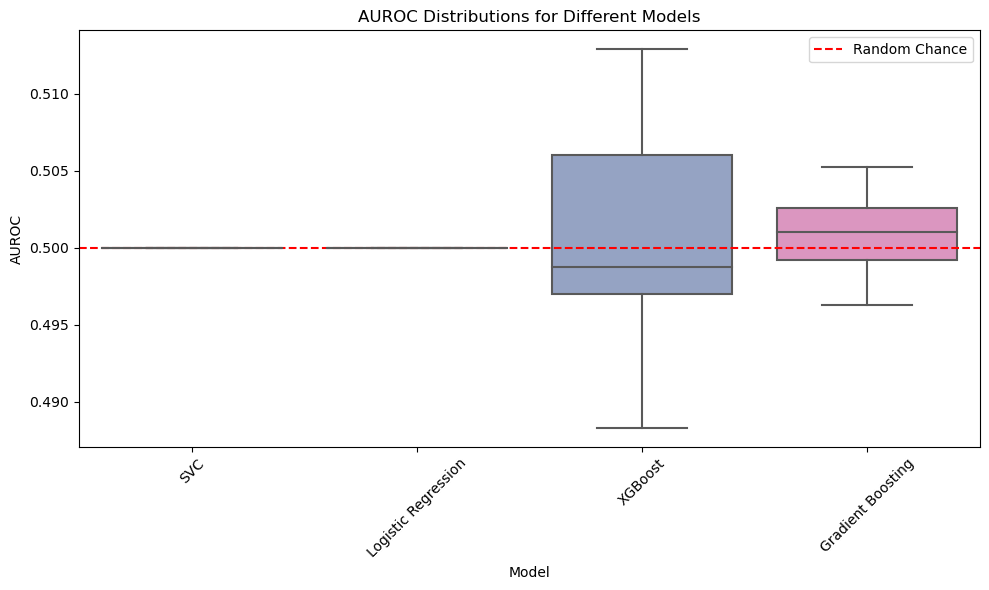

In [73]:
# Re-import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# # Step 1: Create synthetic dataset
# np.random.seed(42)
# data_size = 1000
# synthetic_data = pd.DataFrame({
#     'Humidity': np.random.uniform(20, 100, size=data_size),  # Humidity in percentage
#     'Atmospheric_Temp': np.random.uniform(15, 40, size=data_size),  # Atmospheric temperature
#     'Soil_Temp': np.random.uniform(10, 35, size=data_size),  # Soil temperature
#     'Dew_Point': np.random.uniform(5, 20, size=data_size),  # Dew point
#     'Rainfall': np.random.uniform(0, 50, size=data_size),  # Rainfall
#     'Soil_Moisture': np.random.uniform(0.1, 0.4, size=data_size)  # Soil moisture
# })

# low_soil_moisture_threshold = 0.2
# synthetic_data['Low_Soil_Moisture_Anomaly'] = (
#     synthetic_data['Soil_Moisture'] < low_soil_moisture_threshold).astype(int)

# # Step 2: Define features and target
# features = ['Humidity', 'Atmospheric_Temp', 'Soil_Temp', 'Dew_Point', 'Rainfall']
# target = 'Low_Soil_Moisture_Anomaly'
X = new_data[features]
y = new_data[target]

# Step 3: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Define models
models = {
    "SVC": SVC(probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Step 5: Evaluate models with cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
auroc_scores = {model_name: [] for model_name in models.keys()}

for model_name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, scoring=make_scorer(roc_auc_score), cv=cv, n_jobs=-1)
    auroc_scores[model_name] = scores

# Step 6: Statistical significance testing
anova_result = f_oneway(*[auroc_scores[model] for model in models.keys()])
significance_results = {"ANOVA p-value": anova_result.pvalue}

if anova_result.pvalue < 0.05:
    t_test_results = {}
    model_names = list(models.keys())
    for i in range(len(model_names)):
        for j in range(i + 1, len(model_names)):
            t_stat, p_value = ttest_ind(auroc_scores[model_names[i]], auroc_scores[model_names[j]], equal_var=False)
            t_test_results[f"{model_names[i]} vs {model_names[j]}"] = p_value
    significance_results["Pairwise t-tests"] = t_test_results

# Step 7: Display results and plot
print("Statistical Significance Results:")
print(significance_results)

auroc_df = pd.DataFrame({
    'Model': np.repeat(list(auroc_scores.keys()), [len(scores) for scores in auroc_scores.values()]),
    'AUROC': np.concatenate([scores for scores in auroc_scores.values()])
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=auroc_df, x='Model', y='AUROC', palette='Set2')
plt.axhline(0.5, linestyle='--', color='red', label='Random Chance')
plt.title('AUROC Distributions for Different Models')
plt.xlabel('Model')
plt.ylabel('AUROC')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayo

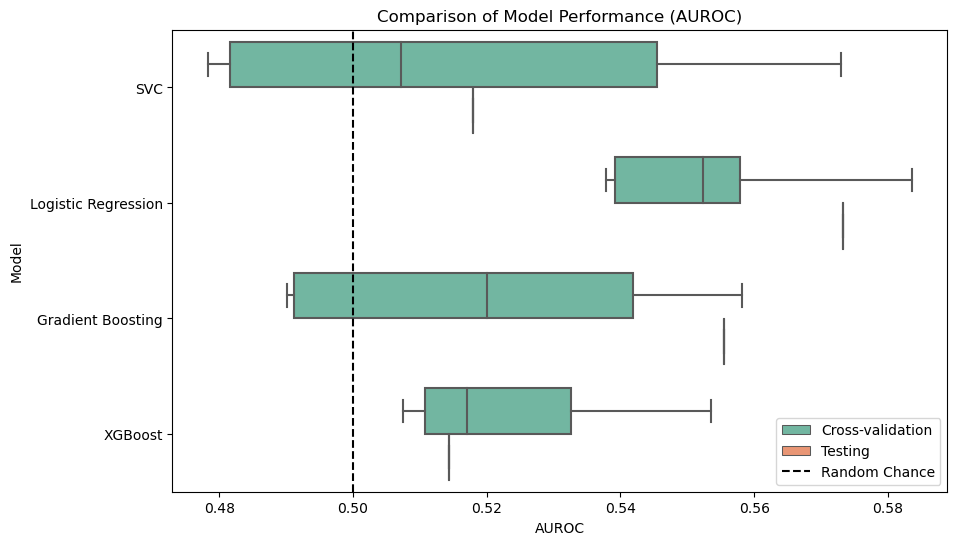

Statistical Test Results (P-Values):
Logistic Regression vs XGBoost: 0.03583131284307159
XGBoost vs Logistic Regression: 0.03583131284307159
Logistic Regression vs Gradient Boosting: 0.06533001150131473
Gradient Boosting vs Logistic Regression: 0.06533001150131473
SVC vs Logistic Regression: 0.10386207376530643
Logistic Regression vs SVC: 0.10386207376530643
SVC vs XGBoost: 0.7335464851162221
XGBoost vs SVC: 0.7335464851162221
Gradient Boosting vs XGBoost: 0.8091504942128911
XGBoost vs Gradient Boosting: 0.8091504942128911
SVC vs Gradient Boosting: 0.8935379010058362
Gradient Boosting vs SVC: 0.8935379010058362


In [238]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Models to evaluate
models = {
    'SVC': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Store AUROC scores
results = {'Model': [], 'Dataset': [], 'AUROC': []}

# Evaluate each model
for name, model in models.items():
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    results['Model'].extend([name] * len(cv_scores))
    results['Dataset'].extend(['Cross-validation'] * len(cv_scores))
    results['AUROC'].extend(cv_scores)
    
    # Testing score
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    test_score = roc_auc_score(y_test, y_pred_proba)
    results['Model'].append(name)
    results['Dataset'].append('Testing')
    results['AUROC'].append(test_score)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Statistical tests between models (cross-validation scores only)
cv_scores_df = results_df[results_df['Dataset'] == 'Cross-validation']
p_values = {}
for model1 in models.keys():
    for model2 in models.keys():
        if model1 != model2:
            scores1 = cv_scores_df[cv_scores_df['Model'] == model1]['AUROC']
            scores2 = cv_scores_df[cv_scores_df['Model'] == model2]['AUROC']
            stat, p = stats.ttest_ind(scores1, scores2)
            p_values[f"{model1} vs {model2}"] = p

# Plot the results
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='AUROC', y='Model', hue='Dataset', palette='Set2')
plt.axvline(0.5, color='black', linestyle='--', label='Random Chance')
plt.title('Comparison of Model Performance (AUROC)')
plt.legend(loc='lower right')
plt.show()

# Display statistical test results
p_values_sorted = {k: v for k, v in sorted(p_values.items(), key=lambda item: item[1])}
print("Statistical Test Results (P-Values):")
for comparison, p_value in p_values_sorted.items():
    print(f"{comparison}: {p_value}")


/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayo

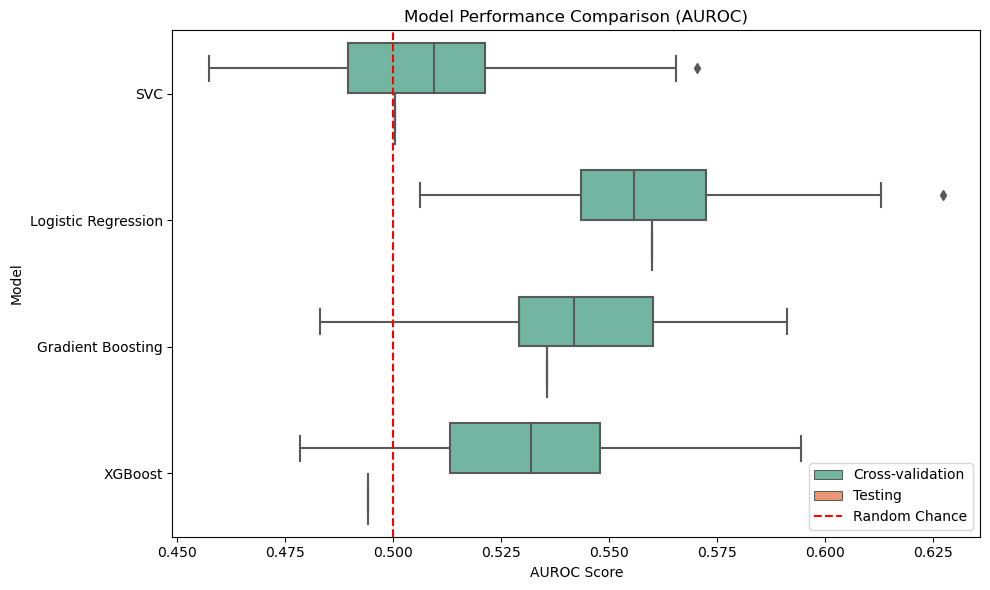

ANOVA Result (p-value): 2.99038534033071e-65

Significant differences found; performing pairwise t-tests...

Pairwise t-test results (p-values):
SVC vs Logistic Regression: 6.990087291431826e-55
SVC vs Gradient Boosting: 4.1533805511206927e-35
SVC vs XGBoost: 4.0208289290305743e-16
Logistic Regression vs Gradient Boosting: 4.2390321123899625e-07
Logistic Regression vs XGBoost: 2.977943154616216e-20
Gradient Boosting vs XGBoost: 1.2610730339107967e-06


In [240]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind

# Features and target
features = ['Humidity', 'Atmospheric_Temp', 'Soil_Temp', 'Dew_Point', 'Rainfall']
target = 'Low_Soil_Moisture_Anomaly'

X = new_data[features]
y = new_data[target]

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Define models
models = {
    "SVC": SVC(probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Step 4: Evaluate models with RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=30, random_state=42)
results = {'Model': [], 'Dataset': [], 'AUROC': []}

for name, model in models.items():
    # Cross-validation AUROC
    cv_scores = cross_val_score(
        model, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    results['Model'].extend([name] * len(cv_scores))
    results['Dataset'].extend(['Cross-validation'] * len(cv_scores))
    results['AUROC'].extend(cv_scores)

    # Testing AUROC
    model.fit(X_train_scaled, y_train)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    test_score = roc_auc_score(y_test, y_pred_proba)
    results['Model'].append(name)
    results['Dataset'].append('Testing')
    results['AUROC'].append(test_score)

# Step 5: Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Step 6: Boxplot for Cross-validation and Testing AUROC
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='AUROC', y='Model', hue='Dataset', palette='Set2')
plt.axvline(0.5, color='red', linestyle='--', label='Random Chance')
plt.title('Model Performance Comparison (AUROC)')
plt.xlabel('AUROC Score')
plt.ylabel('Model')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Step 7: Statistical significance testing (ANOVA and t-tests)
# Only use cross-validation scores for statistical tests
cv_scores_df = results_df[results_df['Dataset'] == 'Cross-validation']

# Perform ANOVA test
anova_result = f_oneway(
    *[cv_scores_df[cv_scores_df['Model'] == model]['AUROC'] for model in models.keys()]
)

print("ANOVA Result (p-value):", anova_result.pvalue)

# If ANOVA is significant, perform pairwise t-tests
if anova_result.pvalue < 0.05:
    print("\nSignificant differences found; performing pairwise t-tests...")
    p_values = {}
    model_names = list(models.keys())
    for i in range(len(model_names)):
        for j in range(i + 1, len(model_names)):
            scores1 = cv_scores_df[cv_scores_df['Model'] == model_names[i]]['AUROC']
            scores2 = cv_scores_df[cv_scores_df['Model'] == model_names[j]]['AUROC']
            t_stat, p_val = ttest_ind(scores1, scores2, equal_var=False)
            p_values[f"{model_names[i]} vs {model_names[j]}"] = p_val
    print("\nPairwise t-test results (p-values):")
    for comparison, p_val in p_values.items():
        print(f"{comparison}: {p_val}")
else:
    print("\nNo significant differences found between models.")

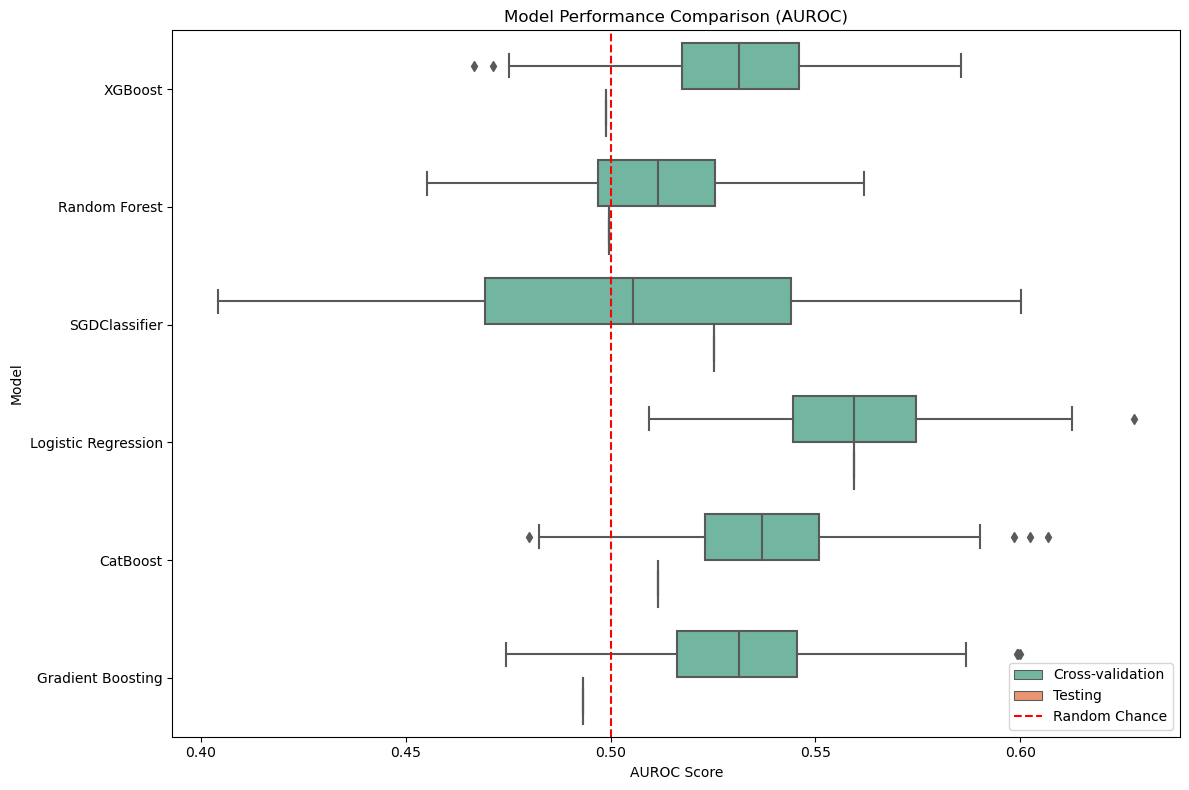

ANOVA Result (p-value): 1.2673679188143692e-62

Significant differences found; performing pairwise t-tests...

Pairwise t-test results (p-values):
XGBoost vs Random Forest: 1.1245841638071687e-12
XGBoost vs SGDClassifier: 8.895800448616543e-09
XGBoost vs Logistic Regression: 3.700063794835536e-24
XGBoost vs CatBoost: 0.0062360125781012535
XGBoost vs Gradient Boosting: 0.3489109153498846
Random Forest vs SGDClassifier: 0.17948774471594653
Random Forest vs Logistic Regression: 1.9975474675926684e-52
Random Forest vs CatBoost: 1.943161485230388e-20
Random Forest vs Gradient Boosting: 9.355701835971884e-15
SGDClassifier vs Logistic Regression: 1.0639274607913197e-28
SGDClassifier vs CatBoost: 4.834735283994981e-13
SGDClassifier vs Gradient Boosting: 4.68848582010298e-10
Logistic Regression vs CatBoost: 3.9596538803697594e-14
Logistic Regression vs Gradient Boosting: 7.460613589347813e-20
CatBoost vs Gradient Boosting: 0.07795093184051706


In [241]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind

X = new_data[features]
y = new_data[target]

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Define best models (replace 'models' with 'best_models')
best_models = {
    'XGBoost': XGBClassifier(
        eval_metric='logloss', learning_rate=0.2, max_depth=7, n_estimators=150, random_state=42
    ),
    'Random Forest': RandomForestClassifier(n_estimators=2, random_state=42),
    'SGDClassifier': SGDClassifier(alpha=0.01, random_state=42),
    'Logistic Regression': LogisticRegression(C=0.01, random_state=42, solver='liblinear'),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(
        learning_rate=0.2, max_depth=7, n_estimators=150, random_state=42
    )
}

# Step 4: Evaluate models with RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=30, random_state=42)
results = {'Model': [], 'Dataset': [], 'AUROC': []}

for name, model in best_models.items():
    # Cross-validation AUROC
    cv_scores = cross_val_score(
        model, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1
    )
    results['Model'].extend([name] * len(cv_scores))
    results['Dataset'].extend(['Cross-validation'] * len(cv_scores))
    results['AUROC'].extend(cv_scores)

    # Testing AUROC
    model.fit(X_train_scaled, y_train)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test_scaled)
    test_score = roc_auc_score(y_test, y_pred_proba)
    results['Model'].append(name)
    results['Dataset'].append('Testing')
    results['AUROC'].append(test_score)

# Step 5: Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Step 6: Boxplot for Cross-validation and Testing AUROC
plt.figure(figsize=(12, 8))
sns.boxplot(data=results_df, x='AUROC', y='Model', hue='Dataset', palette='Set2')
plt.axvline(0.5, color='red', linestyle='--', label='Random Chance')
plt.title('Model Performance Comparison (AUROC)')
plt.xlabel('AUROC Score')
plt.ylabel('Model')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Step 7: Statistical significance testing (ANOVA and t-tests)
# Only use cross-validation scores for statistical tests
cv_scores_df = results_df[results_df['Dataset'] == 'Cross-validation']

# Perform ANOVA test
anova_result = f_oneway(
    *[cv_scores_df[cv_scores_df['Model'] == model]['AUROC'] for model in best_models.keys()]
)

print("ANOVA Result (p-value):", anova_result.pvalue)

# If ANOVA is significant, perform pairwise t-tests
if anova_result.pvalue < 0.05:
    print("\nSignificant differences found; performing pairwise t-tests...")
    p_values = {}
    model_names = list(best_models.keys())
    for i in range(len(model_names)):
        for j in range(i + 1, len(model_names)):
            scores1 = cv_scores_df[cv_scores_df['Model'] == model_names[i]]['AUROC']
            scores2 = cv_scores_df[cv_scores_df['Model'] == model_names[j]]['AUROC']
            t_stat, p_val = ttest_ind(scores1, scores2, equal_var=False)
            p_values[f"{model_names[i]} vs {model_names[j]}"] = p_val
    print("\nPairwise t-test results (p-values):")
    for comparison, p_val in p_values.items():
        print(f"{comparison}: {p_val}")
else:
    print("\nNo significant differences found between models.")

/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayode/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/kayo

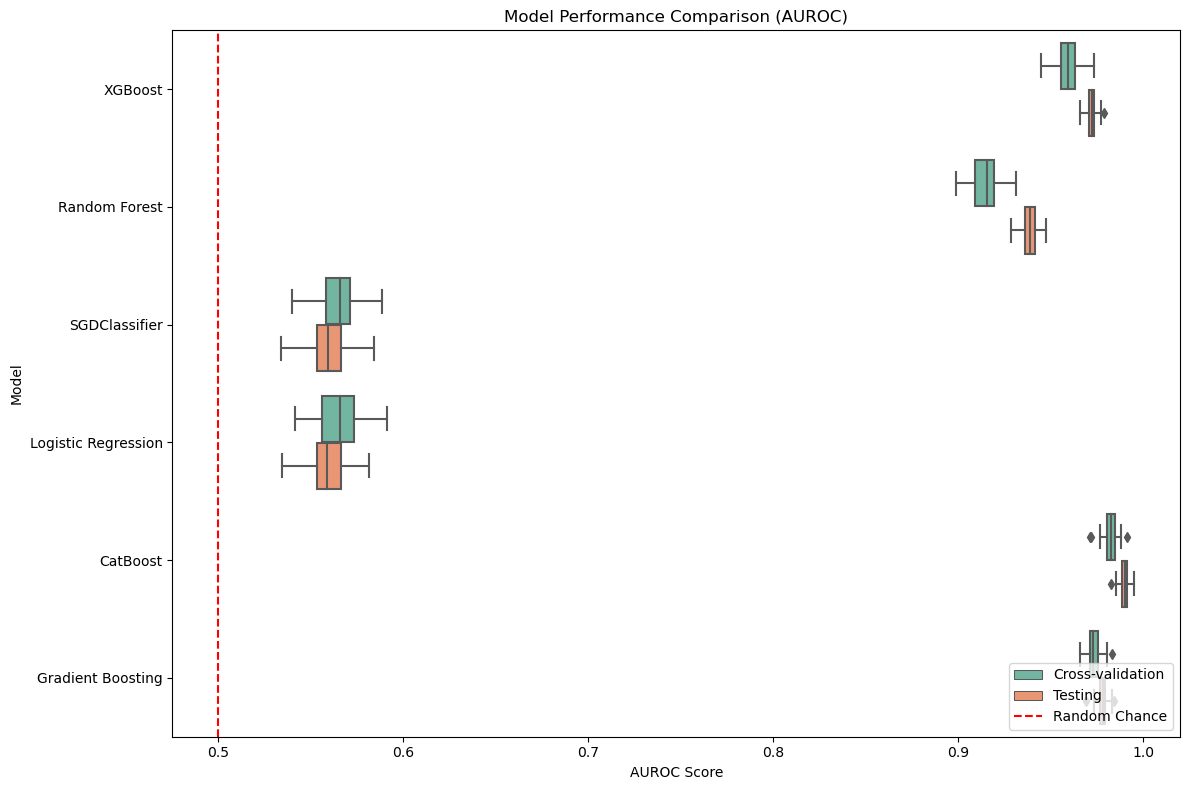

ANOVA Result (p-value): 0.0

Significant differences found; performing pairwise t-tests...

Pairwise t-test results (p-values):
XGBoost vs Random Forest: 4.671802291859479e-70
XGBoost vs SGDClassifier: 1.3677157848188727e-140
XGBoost vs Logistic Regression: 4.165089864318529e-139
XGBoost vs CatBoost: 1.4015179217530583e-45
XGBoost vs Gradient Boosting: 6.654000447690002e-28
Random Forest vs SGDClassifier: 1.0826799899973684e-142
Random Forest vs Logistic Regression: 3.459836780653878e-141
Random Forest vs CatBoost: 2.1233413853863717e-81
Random Forest vs Gradient Boosting: 2.0559828605393523e-75
SGDClassifier vs Logistic Regression: 0.7447442091419054
SGDClassifier vs CatBoost: 3.763733645851578e-117
SGDClassifier vs Gradient Boosting: 3.529150965226253e-116
Logistic Regression vs CatBoost: 2.9994908960795736e-116
Logistic Regression vs Gradient Boosting: 2.7544616342734184e-115
CatBoost vs Gradient Boosting: 7.117440992631913e-29


In [75]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind
from sklearn.utils import resample  # For bootstrapping

# Define features and target
X = balanced_data[features]
y = balanced_data[target]

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Define best models
# best_models = {
#     'XGBoost': XGBClassifier(
#         eval_metric='logloss', learning_rate=0.2, max_depth=7, n_estimators=150, random_state=42
#     ),
#     'Random Forest': RandomForestClassifier(n_estimators=2, random_state=42),
#     'SGDClassifier': SGDClassifier(alpha=0.01, random_state=42),
#     'Logistic Regression': LogisticRegression(C=0.01, random_state=42, solver='liblinear'),
#     'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
#     'Gradient Boosting': GradientBoostingClassifier(
#         learning_rate=0.2, max_depth=7, n_estimators=150, random_state=42
#     )
# }

# Step 4: Evaluate models with RepeatedStratifiedKFold and Bootstrapping
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=13, random_state=42)
results = {'Model': [], 'Dataset': [], 'AUROC': []}

for name, model in best_models.items():
    # Cross-validation AUROC
    cv_scores = cross_val_score(
        model, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1
    )
    results['Model'].extend([name] * len(cv_scores))
    results['Dataset'].extend(['Cross-validation'] * len(cv_scores))
    results['AUROC'].extend(cv_scores)

    # Testing AUROC with bootstrapping
    model.fit(X_train_scaled, y_train)
    bootstrapped_scores = []
    for i in range(50):  # Perform 100 bootstrap samples
        X_test_bootstrap, y_test_bootstrap = resample(X_test_scaled, y_test, random_state=i)
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test_bootstrap)[:, 1]
        else:
            y_pred_proba = model.decision_function(X_test_bootstrap)
        bootstrapped_scores.append(roc_auc_score(y_test_bootstrap, y_pred_proba))
    
    results['Model'].extend([name] * len(bootstrapped_scores))
    results['Dataset'].extend(['Testing'] * len(bootstrapped_scores))
    results['AUROC'].extend(bootstrapped_scores)

# Step 5: Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Step 6: Boxplot for Cross-validation and Testing AUROC
plt.figure(figsize=(12, 8))
sns.boxplot(data=results_df, x='AUROC', y='Model', hue='Dataset', palette='Set2')
plt.axvline(0.5, color='red', linestyle='--', label='Random Chance')
plt.title('Model Performance Comparison (AUROC)')
plt.xlabel('AUROC Score')
plt.ylabel('Model')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Step 7: Statistical significance testing (ANOVA and t-tests)
# Only use cross-validation scores for statistical tests
cv_scores_df = results_df[results_df['Dataset'] == 'Cross-validation']

# Perform ANOVA test
anova_result = f_oneway(
    *[cv_scores_df[cv_scores_df['Model'] == model]['AUROC'] for model in best_models.keys()]
)

print("ANOVA Result (p-value):", anova_result.pvalue)

# If ANOVA is significant, perform pairwise t-tests
if anova_result.pvalue < 0.05:
    print("\nSignificant differences found; performing pairwise t-tests...")
    p_values = {}
    model_names = list(best_models.keys())
    for i in range(len(model_names)):
        for j in range(i + 1, len(model_names)):
            scores1 = cv_scores_df[cv_scores_df['Model'] == model_names[i]]['AUROC']
            scores2 = cv_scores_df[cv_scores_df['Model'] == model_names[j]]['AUROC']
            t_stat, p_val = ttest_ind(scores1, scores2, equal_var=False)
            p_values[f"{model_names[i]} vs {model_names[j]}"] = p_val
    print("\nPairwise t-test results (p-values):")
    for comparison, p_val in p_values.items():
        print(f"{comparison}: {p_val}")
else:
    print("\nNo significant differences found between models.")

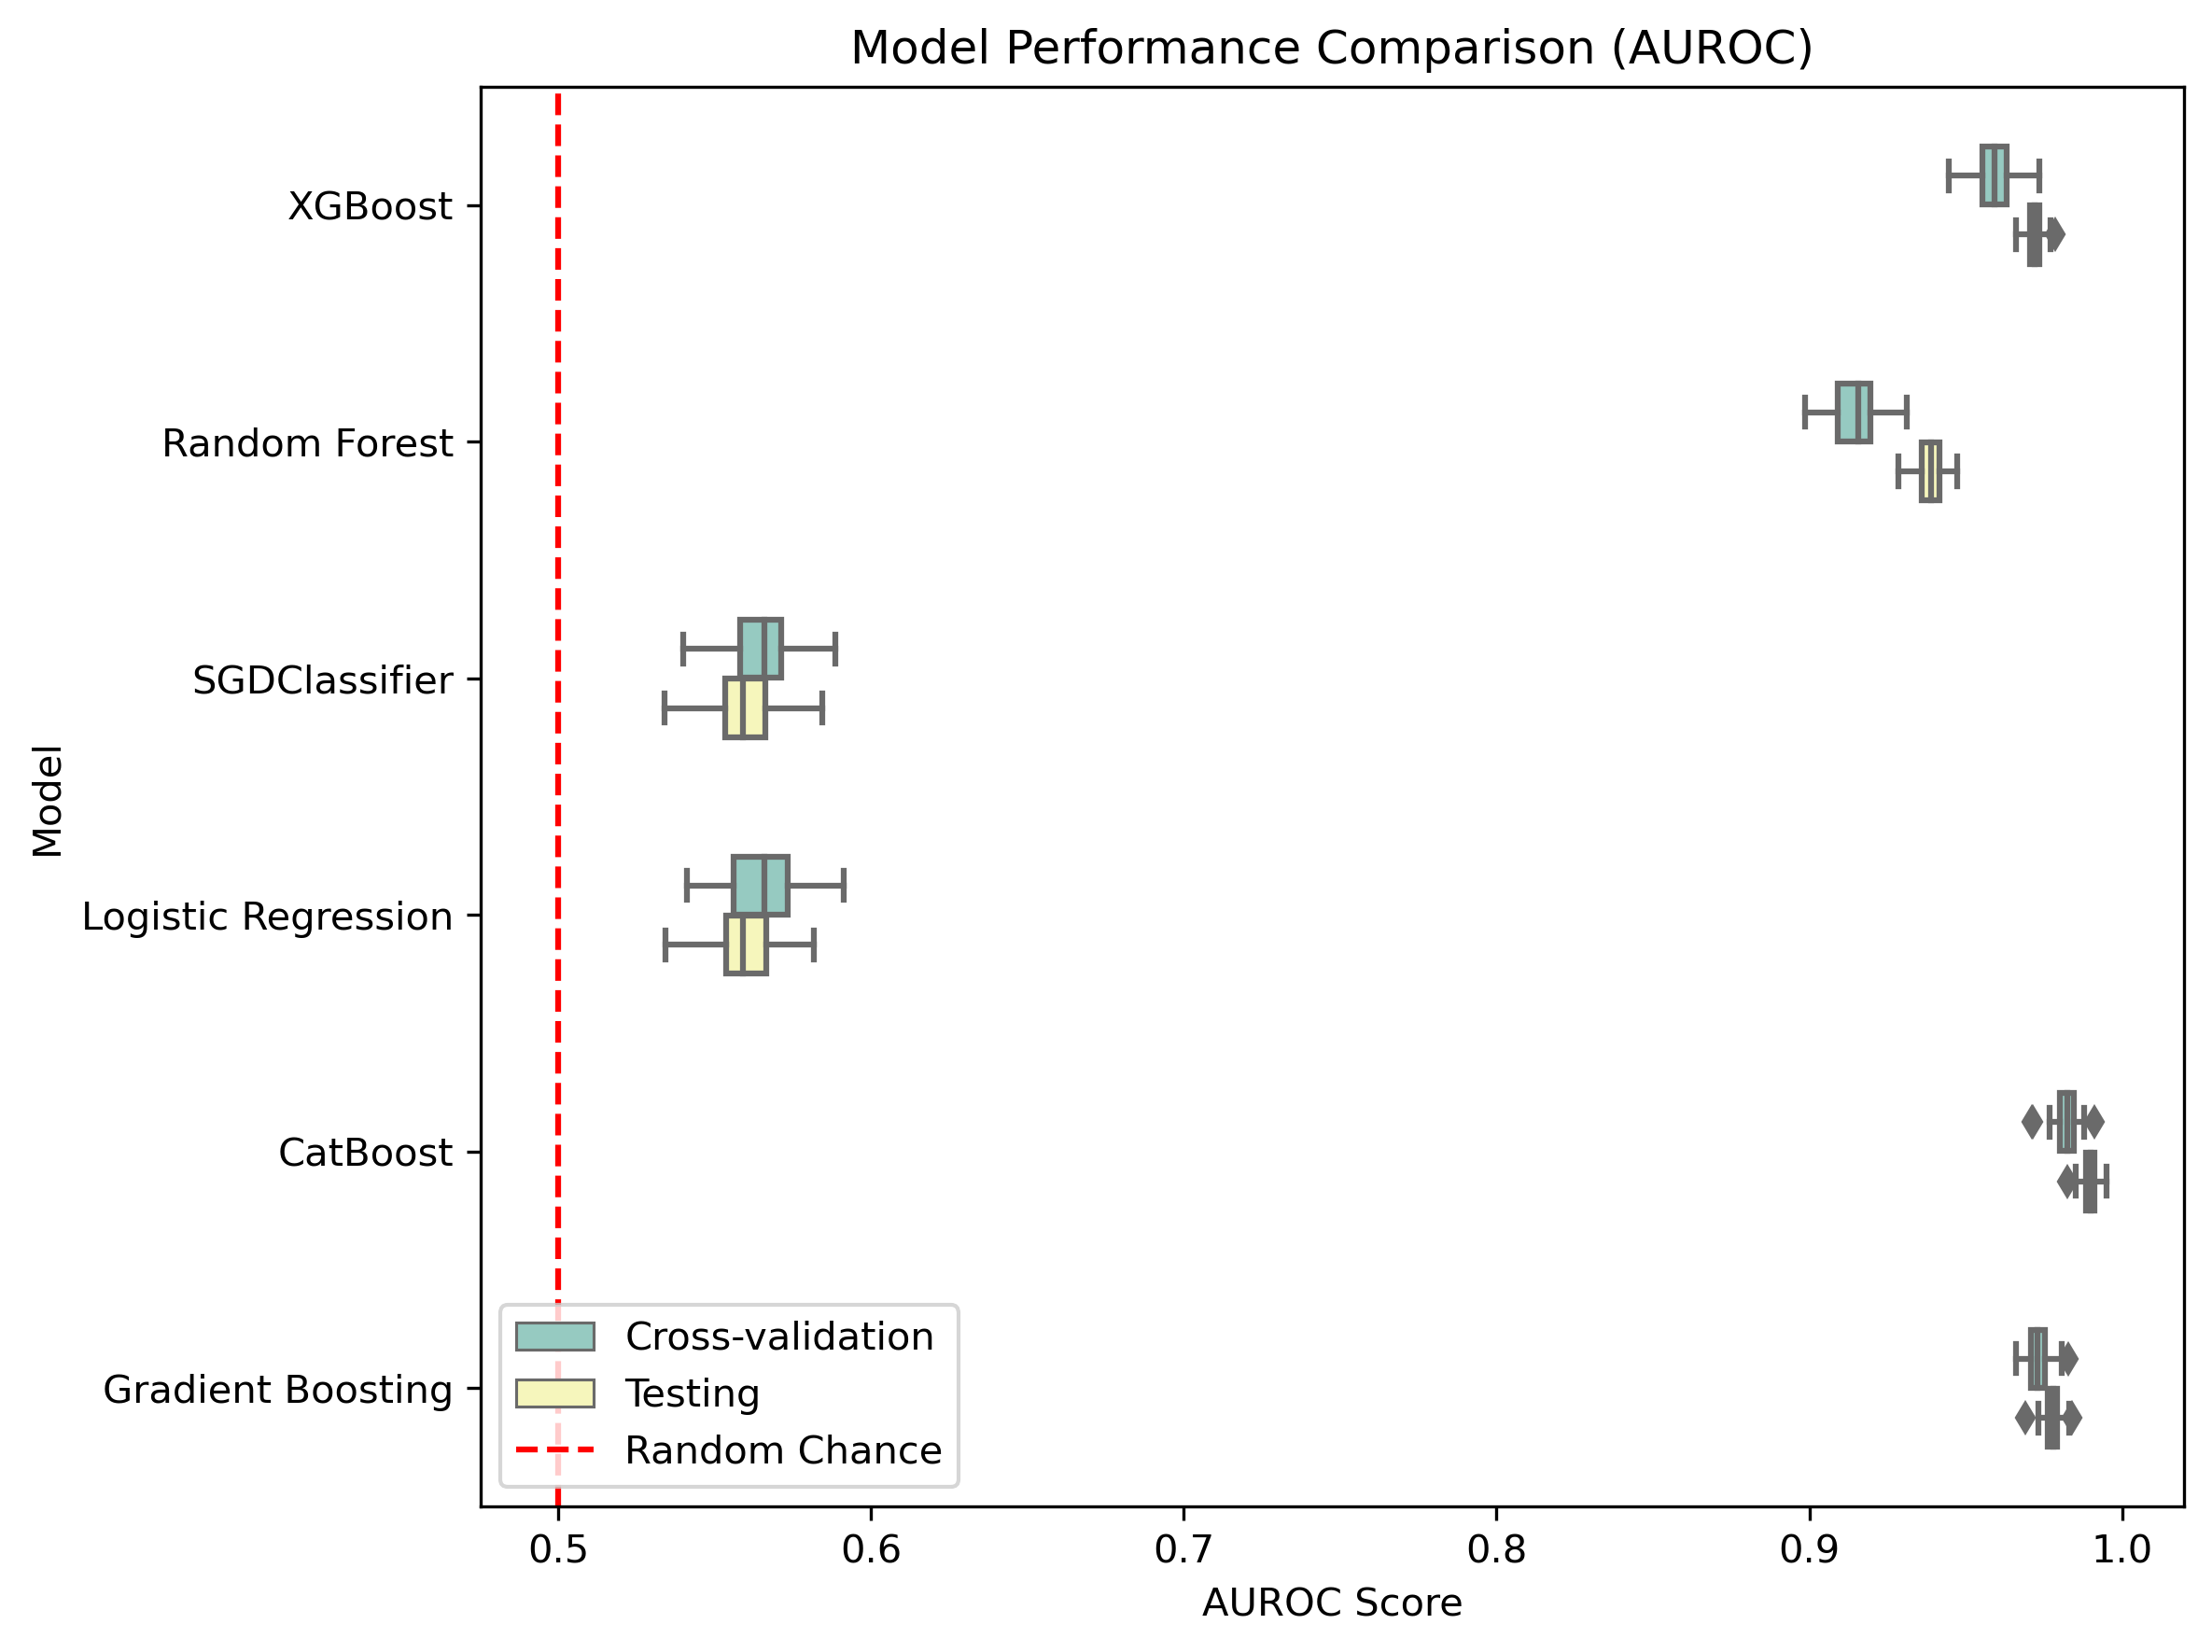

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the width of boxplots and change the color palette
plt.figure(figsize=(8, 6), dpi=300)
sns.boxplot(
    data=results_df, 
    x='AUROC', 
    y='Model', 
    hue='Dataset', 
    palette='Set3',  # New color palette
    width=0.5            # Reduce boxplot width
)
# strip_plot = sns.stripplot(y='Model', x='AUROC', hue='Dataset', data=results_df, orient='h', color='k', jitter=True, dodge=True, alpha=0.6)
# strip_plot.legend_.remove()  # Remove legend for strip plot
plt.axvline(0.5, color='red', linestyle='--', label='Random Chance')
plt.title('Model Performance Comparison (AUROC)')
plt.xlabel('AUROC Score')
plt.ylabel('Model')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [76]:
from scipy.stats import ttest_ind, wilcoxon

# Statistical testing: Cross-validation vs. Testing
stat_results = []
models = results_df['Model'].unique()

for model in models:
    # Separate CV and Testing scores
    cv_scores = results_df[(results_df['Model'] == model) & (results_df['Dataset'] == 'Cross-validation')]['AUROC']
    test_scores = results_df[(results_df['Model'] == model) & (results_df['Dataset'] == 'Testing')]['AUROC']
    
    # Perform paired statistical test
    if len(test_scores) > 1:  # Ensure enough test samples for meaningful comparison
        try:
            t_stat, p_val = ttest_ind(cv_scores, test_scores, equal_var=False)  # Use t-test
            stat_results.append({"Model": model, "Test": "t-test", "P-value": p_val})
        except Exception:
            w_stat, p_val = wilcoxon(cv_scores, test_scores)  # Use Wilcoxon test if t-test fails
            stat_results.append({"Model": model, "Test": "Wilcoxon", "P-value": p_val})
    else:
        stat_results.append({"Model": model, "Test": "Insufficient Data", "P-value": None})

# Convert results to DataFrame for easy viewing
stat_results_df = pd.DataFrame(stat_results)
stat_results_df

,Model,Test,P-value
0,XGBoost,t-test,2.483222e-25
1,Random Forest,t-test,8.190266e-42
2,SGDClassifier,t-test,9.470053e-03
3,Logistic Regression,t-test,4.820075e-03
4,CatBoost,t-test,1.874583e-24
5,Gradient Boosting,t-test,7.015609e-13


In [98]:
stat_results_df.to_csv('stat_results.csv', index=False)

In [77]:
generalizability_ratios = []
for model in models:
    cv_mean = results_df[(results_df['Model'] == model) & (results_df['Dataset'] == 'Cross-validation')]['AUROC'].mean()
    test_mean = results_df[(results_df['Model'] == model) & (results_df['Dataset'] == 'Testing')]['AUROC'].mean()
    ratio = test_mean / cv_mean
    generalizability_ratios.append({"Model": model, "Generalizability Ratio": ratio})

gen_ratio_df = pd.DataFrame(generalizability_ratios)
gen_ratio_df

,Model,Generalizability Ratio
0,XGBoost,1.013222
1,Random Forest,1.026284
2,SGDClassifier,0.990511
3,Logistic Regression,0.989653
4,CatBoost,1.007543
5,Gradient Boosting,1.004875


In [99]:
gen_ratio_df.to_csv('gen_ratio_df.csv', index=False)

In [101]:
mean_diff = []
for model in models:
    cv_scores = results_df[(results_df['Model'] == model) & (results_df['Dataset'] == 'Cross-validation')]['AUROC']
    test_scores = results_df[(results_df['Model'] == model) & (results_df['Dataset'] == 'Testing')]['AUROC']
    mean_diff.append({"Model": model, "Mean Difference (CV - Test)": np.mean(cv_scores) - np.mean(test_scores)})

mean_diff_df = pd.DataFrame(mean_diff)
mean_diff_df

,Model,Mean Difference (CV - Test)
0,XGBoost,-0.012683
1,Random Forest,-0.024039
2,SGDClassifier,0.005357
3,Logistic Regression,0.005848
4,CatBoost,-0.007409
5,Gradient Boosting,-0.004743


/tmp/ipykernel_3024628/2817795643.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cv_scores, label='Cross-Validation', shade=True)
/tmp/ipykernel_3024628/2817795643.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(bootstrapped_scores, label='Testing', shade=True)


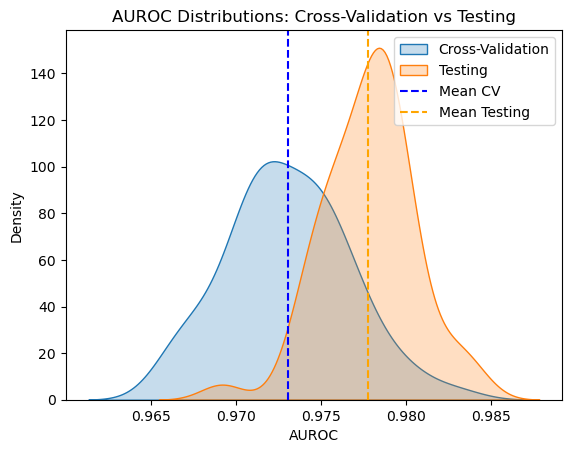

In [100]:
sns.kdeplot(cv_scores, label='Cross-Validation', shade=True)
sns.kdeplot(bootstrapped_scores, label='Testing', shade=True)
plt.axvline(np.mean(cv_scores), color='blue', linestyle='--', label='Mean CV')
plt.axvline(np.mean(bootstrapped_scores), color='orange', linestyle='--', label='Mean Testing')
plt.title('AUROC Distributions: Cross-Validation vs Testing')
plt.legend()
plt.show()

In [102]:
from scipy.stats import wilcoxon
from numpy import mean

# Perform Wilcoxon test
stat, p_val = wilcoxon(cv_scores[:len(bootstrapped_scores)], bootstrapped_scores)
print(f"Wilcoxon Test: Statistic = {stat}, P-value = {p_val}")

# Compute effect size (Cohen's d)
diff = np.array(cv_scores[:len(bootstrapped_scores)]) - np.array(bootstrapped_scores)
cohen_d = mean(diff) / np.std(diff)
print(f"Cohen's d (Effect Size): {cohen_d}")

Wilcoxon Test: Statistic = 86.0, P-value = 1.016310324350643e-07
Cohen's d (Effect Size): -1.0594998841638288


In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV

# Inner loop: Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
}

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=inner_cv, scoring='roc_auc', n_jobs=-1)

# Outer loop: Model evaluation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nested_scores = cross_val_score(grid_search, X_train_scaled, y_train, cv=outer_cv, scoring='roc_auc')

print(f"Nested CV AUROC: Mean = {np.mean(nested_scores):.3f}, Std = {np.std(nested_scores):.3f}")

In [249]:
best_models['XGBoost']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [250]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'lambda': [1, 2],
    'alpha': [0, 0.1]
}

# Initialize the model
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Grid search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best model
best_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 8748 candidates, totalling 43740 fits
Best Parameters: {'alpha': 0.1, 'colsample_bytree': 1.0, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.8}


In [251]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
cv_scores = cross_val_score(best_xgb, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

# Testing with bootstrapping
bootstrapped_scores = []
for i in range(50):  # 100 bootstrap samples
    X_test_bootstrap, y_test_bootstrap = resample(X_test_scaled, y_test, random_state=i)
    best_xgb.fit(X_train_scaled, y_train)
    y_pred_proba = best_xgb.predict_proba(X_test_bootstrap)[:, 1]
    bootstrapped_scores.append(roc_auc_score(y_test_bootstrap, y_pred_proba))

# Summary of scores
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)
test_mean = np.mean(bootstrapped_scores)
test_std = np.std(bootstrapped_scores)

print(f"Cross-validation AUROC: Mean = {cv_mean:.3f}, Std = {cv_std:.3f}")
print(f"Testing AUROC (Bootstrapped): Mean = {test_mean:.3f}, Std = {test_std:.3f}")

Cross-validation AUROC: Mean = 0.565, Std = 0.023
Testing AUROC (Bootstrapped): Mean = 0.543, Std = 0.017


In [252]:
len(cv_scores[:len(bootstrapped_scores)])

50

In [253]:
from scipy.stats import ttest_rel, wilcoxon

# Mean Difference
mean_diff = cv_mean - test_mean
print(f"Mean Difference (CV - Test): {mean_diff:.3f}")

# Generalizability Ratio
gen_ratio = test_mean / cv_mean
print(f"Generalizability Ratio: {gen_ratio:.3f}")

# Paired T-Test
t_stat, p_val = ttest_rel(cv_scores[:len(bootstrapped_scores)], bootstrapped_scores)
print(f"Paired T-Test: T-statistic = {t_stat:.3f}, P-value = {p_val:.3f}")

# Wilcoxon Signed-Rank Test (alternative to t-test)
w_stat, w_p_val = wilcoxon(cv_scores[:len(bootstrapped_scores)], bootstrapped_scores)
print(f"Wilcoxon Test: Statistic = {w_stat}, P-value = {w_p_val}")

Mean Difference (CV - Test): 0.022
Generalizability Ratio: 0.962
Paired T-Test: T-statistic = 5.769, P-value = 0.000
Wilcoxon Test: Statistic = 145.0, P-value = 1.9919455004886565e-06


/tmp/ipykernel_2930880/4082156548.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cv_scores, label='Cross-Validation', shade=True)
/tmp/ipykernel_2930880/4082156548.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(bootstrapped_scores, label='Testing', shade=True)


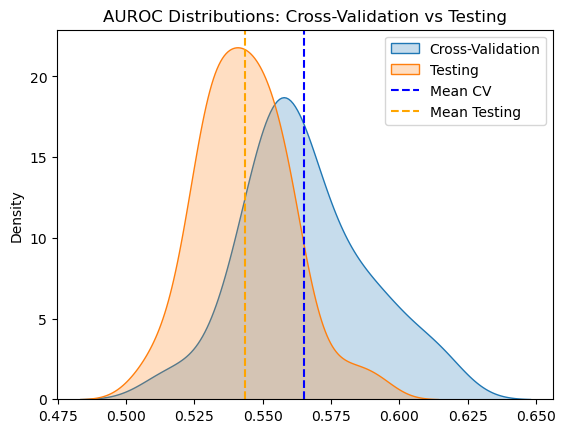

In [254]:
import seaborn as sns
import matplotlib.pyplot as plt

# KDE Plot
sns.kdeplot(cv_scores, label='Cross-Validation', shade=True)
sns.kdeplot(bootstrapped_scores, label='Testing', shade=True)
plt.axvline(cv_mean, color='blue', linestyle='--', label='Mean CV')
plt.axvline(test_mean, color='orange', linestyle='--', label='Mean Testing')
plt.title('AUROC Distributions: Cross-Validation vs Testing')
plt.legend()
plt.show()

In [255]:
X_train_scaled.shape

(4459, 5)

In [256]:
X_train_balanced.columns

Index(['Humidity', 'Atmospheric_Temp', 'Soil_Temp', 'Dew_Point', 'Rainfall'], dtype='object')

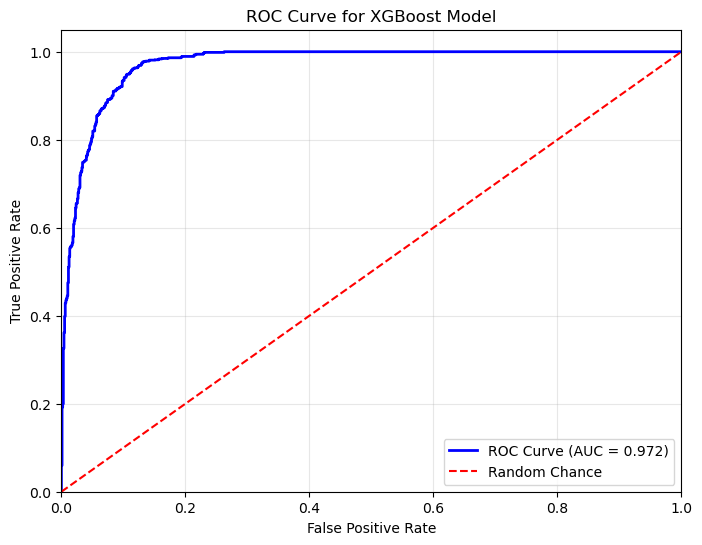

In [257]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Fit the best XGBoost model on the training data
best_models['XGBoost'].fit(X_train_balanced, y_train_balanced)

# Predict probabilities for the test set
y_pred_proba_test = best_models['XGBoost'].predict_proba(X_test_balanced[['Humidity', 'Atmospheric_Temp', 'Soil_Temp', 'Dew_Point', 'Rainfall']])[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_balanced, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve for XGBoost Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()